In [1]:
#=======================================
# Imports
#=======================================
import numpy as np
import matplotlib.pyplot as plt
import glob
import xarray
import datetime
import calendar
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
import matplotlib
import pickle
import pandas as pd
import os
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from scipy.interpolate import NearestNDInterpolator as nn
from matplotlib.patches import Rectangle
from matplotlib import cm
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
#import palettable
import h5py
import scipy
import random
import PseudoNetCDF as pnc
#from matplotlib import rc

# Read in dictionaries (as "pickle" files) of cloud-top variables for each of the 9 simulations from the manuscript
## Complete 3D data for the CNTL simulation are available on the NCCS Data Portal (https://portal.nccs.nasa.gov/datashare/giss-camp2ex/)
## 3D output from the BIN_TURB_10X simulation is very large, but can be made available upon request
## Cloud-top calculations can be recreated following the methodology in the manuscript (Section 4.3)

In [2]:
sim_name_1 = 'cntl'
sim_name_2 = 'fixed_aero'
sim_name_3 = 'kk'
sim_name_4 = 'no_cc'
sim_name_5 = 'fixed_aero_no_cc'
sim_name_6 = '2x'
sim_name_7 = 'bin'
sim_name_8 = 'bin_turb'
sim_name_9 = 'bin_turb_10x'
sims = [sim_name_1,sim_name_2,sim_name_3,sim_name_4,sim_name_5,sim_name_6,sim_name_7,sim_name_8,sim_name_9]
print(sims)

['cntl', 'fixed_aero', 'kk', 'no_cc', 'fixed_aero_no_cc', '2x', 'bin', 'bin_turb', 'bin_turb_10x']


In [3]:
path = '/discover/nobackup/mwstanfo/dharma_post/cloud_top/'

# Initialize dictionaries
all_sims_2d_dict = {}

for sim in sims:
    tmp_2d_dict = pickle.load(open(path+sim+'_2D_dict_9-12hrs_v3.p','rb'))    
    all_sims_2d_dict[sim] = tmp_2d_dict

# Define CTH bins used to calculate percentiles

In [4]:
cth_bins = np.arange(0,8,1)
cth_midbins = np.array([(0.5*(cth_bins[dd]+cth_bins[dd+1])) for dd in range(len(cth_bins)-1)])

# Read in RSP files, also publicly availble on the CAMP2Ex data portal, and calculate percentiles of Nd and Reff for height bins

In [5]:
# RSP files
path = '/discover/nobackup/mwstanfo/camp2ex_data/rsp/20190925/v2/'
files = sorted(glob.glob(path+'*.h5'))
num_files = len(files)

time_arr = []
cth_arr = []
ctt_arr = []
Reff_arr = []
ve_arr = []
tau_arr = []
phase_arr = []
nd_arr = []
lwp_arr = []
cloud_test_arr = []


for tt in range(num_files):
    #print('% Done:',(tt+1)/num_files*100.)
    
    file_name = files[tt]
    file_time = file_name.split('/')[-1]
    file_time = file_time.split('.')[0]
    file_time = file_time.split('_')[-2]
    

    infile = h5py.File(file_name,"r")
    keys_list = list(infile.keys())
    data = infile['Data']
    geom = infile['Geometry']
    time_secs = np.array(data['Product_Time_Seconds'])# seconds after midnight
    base_time = datetime.datetime(2019,9,25)
    # Convert to datetimes
    time = np.array([base_time + datetime.timedelta(seconds=time_secs[dd]) for dd in range(len(time_secs))])
    #alt = np.array(geom['Collocated_Altitude'])
    cloud_test_passed = np.squeeze(np.array(data['Cloud_Test_Passed']))
    cloud_top_alt = np.array(data['Cloud_Top_Altitude'])[0,:]
    cloud_top_temp = np.array(data['Cloud_Top_Temperature'])
    #print(np.shape(data['Cloud_Top_Temperature']))
    #print(aaa)
    cloud_liquid_index = np.array(data['Cloud_Liquid_Index'])[:,4]
    #print(np.shape(cloud_liquid_index))
    #print(aaaa)
    cloud_bow_optical_thickness = np.array(data['Cloud_Bow_Optical_Thickness'])
    cloud_bow_droplet_effective_radius = np.array(data['Cloud_Bow_Droplet_Effective_Radius'])
    cloud_bow_droplet_effective_variance = np.array(data['Cloud_Bow_Droplet_Effective_Variance'])
    cloud_bow_droplet_number_concentration_adiabatic = np.array(data['Cloud_Bow_Droplet_Number_Concentration_Adiabatic'])
    cloud_bow_liquid_water_path = np.array(data['Cloud_Bow_Liquid_Water_Path'])
    
    time_arr.append(time)
    cth_arr.append(cloud_top_alt)
    Reff_arr.append(cloud_bow_droplet_effective_radius)
    ve_arr.append(cloud_bow_droplet_effective_variance)
    tau_arr.append(cloud_bow_optical_thickness)
    phase_arr.append(cloud_liquid_index)
    cloud_test_arr.append(cloud_test_passed)
    nd_arr.append(cloud_bow_droplet_number_concentration_adiabatic)
    lwp_arr.append(cloud_bow_liquid_water_path)
    ctt_arr.append(cloud_top_temp)
    
time_arr = np.array(time_arr,dtype=object)
cth_arr = np.array(cth_arr,dtype=object)
ctt_arr = np.array(ctt_arr,dtype=object)
Reff_arr = np.array(Reff_arr,dtype=object)
ve_arr = np.array(ve_arr,dtype=object)
tau_arr = np.array(tau_arr,dtype=object)
phase_arr = np.array(phase_arr,dtype=object)
cloud_test_arr = np.array(cloud_test_arr,dtype=object)
nd_arr = np.array(nd_arr,dtype=object)
lwp_arr = np.array(lwp_arr,dtype=object)

time_arr = np.concatenate(time_arr,axis=0)
cth_arr = np.concatenate(cth_arr,axis=0)
ctt_arr = np.concatenate(ctt_arr,axis=0)
tau_arr = np.concatenate(tau_arr,axis=0)
Reff_arr = np.concatenate(Reff_arr,axis=0)
ve_arr = np.concatenate(ve_arr,axis=0)
phase_arr = np.concatenate(phase_arr,axis=0)
cloud_test_arr = np.concatenate(cloud_test_arr,axis=0)
nd_arr = np.concatenate(nd_arr,axis=0)
lwp_arr = np.concatenate(lwp_arr,axis=0)



rsp_var_dict = {'time':time_arr,\
            'cth':cth_arr,\
            'ctt':ctt_arr,\
            'Reff':Reff_arr,\
            'v_e':ve_arr,\
            'tau':tau_arr,\
            'phase':phase_arr,\
            'nd':nd_arr,\
            'lwp':lwp_arr,\
            'cloud_test':cloud_test_arr}

if True:
    dumid = np.where((rsp_var_dict['nd'] > -999.) & (rsp_var_dict['cth'] > 0.))[0]
    for key,val in rsp_var_dict.items():
        #print(key,np.shape(val))
        rsp_var_dict[key] = val[dumid]
if False:
    for key,val in var_dict.items():
        print(key,np.shape(val),np.max(val))
    
    
    
tmp_keys = ['cth','Reff','nd','lwp','ctt','v_e']
tmp_keys2 = ['mean','10','25','50','75','90']

rsp_ct_perc_dict = {}
for tmp_key in tmp_keys:
    rsp_ct_perc_dict[tmp_key] = {}
    for tmp_key2 in tmp_keys2:
        rsp_ct_perc_dict[tmp_key][tmp_key2] = []


rsp_samp_size = 0.
for kk in range(len(cth_bins)-1):
    dumid = np.where( (rsp_var_dict['cth']*1.e-3 >= cth_bins[kk]) & (rsp_var_dict['cth']*1.e-3 < cth_bins[kk+1]) )
    dumfrac = np.size(dumid)/np.size(rsp_var_dict['cth'])
    if np.size(dumid) > 0.:
        rsp_samp_size = rsp_samp_size + np.size(dumid)
    
    for tmp_key in tmp_keys:
        #if dumfrac < 0.001:
        if np.size(dumid) < 10.:
            for tmp_key2 in tmp_keys2:
                rsp_ct_perc_dict[tmp_key][tmp_key2].append(np.nan)
            continue
        else:
            rsp_ct_perc_dict[tmp_key]['mean'].append(np.mean(rsp_var_dict[tmp_key][dumid]))
            rsp_ct_perc_dict[tmp_key]['10'].append(np.percentile(rsp_var_dict[tmp_key][dumid],10))
            rsp_ct_perc_dict[tmp_key]['25'].append(np.percentile(rsp_var_dict[tmp_key][dumid],25))
            rsp_ct_perc_dict[tmp_key]['50'].append(np.percentile(rsp_var_dict[tmp_key][dumid],50))
            rsp_ct_perc_dict[tmp_key]['75'].append(np.percentile(rsp_var_dict[tmp_key][dumid],75))
            rsp_ct_perc_dict[tmp_key]['90'].append(np.percentile(rsp_var_dict[tmp_key][dumid],90))

for tmp_key in tmp_keys:
    for tmp_key2 in tmp_keys2:
        rsp_ct_perc_dict[tmp_key][tmp_key2] = np.array(rsp_ct_perc_dict[tmp_key][tmp_key2])

/gpfsm/dnb33/tdirs/batch/slurm.42931965.mwstanfo/ipykernel_43689/4211333487.py:31: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  time_secs = np.array(data['Product_Time_Seconds'])# seconds after midnight
/gpfsm/dnb33/tdirs/batch/slurm.42931965.mwstanfo/ipykernel_43689/4211333487.py:36: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  cloud_test_passed = np.squeeze(np.array(data['Cloud_Test_Passed']))
/gpfsm/dnb33/tdirs/batch/slurm.42931965.mwstanfo/ipykernel_43689/4211333487.py:37: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  cloud_top_alt = np.array(data['Cloud_Top_Altitude'])[0,:]
/gpfsm/dnb33/tdirs/batch/slurm.429319

# Calculate cloud-top statistics for bulk simulations

In [6]:
bulk_sims = sims[0:-3]

ct_stats_dict = {}

dumxx = 0
# Loop through simulations
for sim in bulk_sims:
    print('Simulation:',sim)
    
    dum_time = all_sims_2d_dict[sim]['time']
    dum_time = dum_time/3600.    
    
    #start_id = 0
    # Read in cloud top variables
    tmp_cth = all_sims_2d_dict[sim]['cth']
    tmp_ctt = all_sims_2d_dict[sim]['ctt']
    tmp_ct_rho = all_sims_2d_dict[sim]['ct_rho']
    tmp_clwp = all_sims_2d_dict[sim]['clwp']
    tmp_lwp = all_sims_2d_dict[sim]['lwp']
    tmp_rwp = all_sims_2d_dict[sim]['rwp']
    tmp_ct_qncloud_cc = all_sims_2d_dict[sim]['ct_qncloud']
    tmp_ct_qnl_cc = all_sims_2d_dict[sim]['ct_qnl']
    tmp_ct_qnl_int_cc = all_sims_2d_dict[sim]['ct_qnl_int']
    tmp_ct_qnl_lt_100um_cc = all_sims_2d_dict[sim]['ct_qnl_lt_100um']
    tmp_ct_qnl_lt_200um_cc = all_sims_2d_dict[sim]['ct_qnl_lt_200um']
    tmp_ct_reff_c = all_sims_2d_dict[sim]['ct_reff_c']
    tmp_ct_reff_c_int = all_sims_2d_dict[sim]['ct_reff_c_int']
    tmp_ct_veff_c_int = all_sims_2d_dict[sim]['ct_veff_c_int']
    tmp_ct_reff_l = all_sims_2d_dict[sim]['ct_reff_l']
    tmp_ct_reff_l_lt_100um = all_sims_2d_dict[sim]['ct_reff_l_lt_100um']
    tmp_ct_reff_l_lt_200um = all_sims_2d_dict[sim]['ct_reff_l_lt_200um']
    tmp_ct_veff_l = all_sims_2d_dict[sim]['ct_veff_l']
    tmp_ct_veff_l_lt_100um = all_sims_2d_dict[sim]['ct_veff_l_lt_100um']
    tmp_ct_veff_l_lt_200um = all_sims_2d_dict[sim]['ct_veff_l_lt_200um']
    tmp_time = all_sims_2d_dict[sim]['time']
    
    
    #dumid = np.where(tmp_cth > 0.)
    dumid = np.where( (tmp_cth > 0.) & (tmp_ct_qnl_lt_200um_cc > 1.) )
    tmp_cth = tmp_cth[dumid]*1.e-3
    print('# of samples:',len(tmp_cth))
    tmp_ctt = tmp_ctt[dumid]
    tmp_ct_rho = tmp_ct_rho[dumid]
    tmp_ct_qncloud_cc = tmp_ct_qncloud_cc[dumid]
    tmp_ct_qnl_cc = tmp_ct_qnl_cc[dumid]
    tmp_ct_qnl_int_cc = tmp_ct_qnl_int_cc[dumid]
    tmp_ct_qnl_lt_100um_cc = tmp_ct_qnl_lt_100um_cc[dumid]
    tmp_ct_qnl_lt_200um_cc = tmp_ct_qnl_lt_200um_cc[dumid]
    tmp_ct_reff_c = tmp_ct_reff_c[dumid]
    tmp_ct_reff_c_int = tmp_ct_reff_c_int[dumid]
    tmp_ct_veff_c_int = tmp_ct_veff_c_int[dumid]
    tmp_ct_reff_l = tmp_ct_reff_l[dumid]
    tmp_ct_reff_l_lt_100um = tmp_ct_reff_l_lt_100um[dumid]
    tmp_ct_reff_l_lt_200um = tmp_ct_reff_l_lt_200um[dumid]
    tmp_ct_veff_l = tmp_ct_veff_l[dumid]
    tmp_ct_veff_l_lt_100um = tmp_ct_veff_l_lt_100um[dumid]
    tmp_ct_veff_l_lt_200um = tmp_ct_veff_l_lt_200um[dumid]
    tmp_clwp = tmp_clwp[dumid]
    tmp_rwp = tmp_rwp[dumid]
    tmp_lwp = tmp_lwp[dumid]
    tmp_ct_qncloud = tmp_ct_qncloud_cc/tmp_ct_rho/1.e-6
    tmp_ct_qnl = tmp_ct_qnl_cc/tmp_ct_rho/1.e-6
    tmp_ct_qnl_int = tmp_ct_qnl_int_cc/tmp_ct_rho/1.e-6
    tmp_ct_qnl_lt_100um = tmp_ct_qnl_lt_100um_cc/tmp_ct_rho/1.e-6
    tmp_ct_qnl_lt_200um = tmp_ct_qnl_lt_200um_cc/tmp_ct_rho/1.e-6
        
    
    #=============================================================
    # Attempt to randomly sampled
    #=============================================================
    if False:
        #target_N = 10000
        target_N = int(rsp_samp_size)
        num_samps = len(tmp_cth)
        samp_list = list(np.arange(0,num_samps,1))
        dumid = random.sample(samp_list,target_N)
        print('# of samples:',len(dumid))
        tmp_cth = tmp_cth[dumid]
        tmp_ctt = tmp_ctt[dumid]
        tmp_ct_rho = tmp_ct_rho[dumid]
        tmp_ct_qncloud_cc = tmp_ct_qncloud_cc[dumid]
        tmp_ct_qnl_cc = tmp_ct_qnl_cc[dumid]
        tmp_ct_qnl_int_cc = tmp_ct_qnl_int_cc[dumid]
        tmp_ct_qnl_lt_100um_cc = tmp_ct_qnl_lt_100um_cc[dumid]
        tmp_ct_qnl_lt_200um_cc = tmp_ct_qnl_lt_200um_cc[dumid]
        tmp_ct_reff_c = tmp_ct_reff_c[dumid]
        tmp_ct_reff_l = tmp_ct_reff_l[dumid]
        tmp_ct_reff_l_lt_100um = tmp_ct_reff_l_lt_100um[dumid]
        tmp_ct_reff_l_lt_200um = tmp_ct_reff_l_lt_200um[dumid]
        tmp_clwp = tmp_clwp[dumid]
        tmp_rwp = tmp_rwp[dumid]
        tmp_lwp = tmp_lwp[dumid]
        tmp_ct_qncloud = tmp_ct_qncloud[dumid]
        tmp_ct_qnl = tmp_ct_qnl[dumid]
        tmp_ct_qnl_int = tmp_ct_qnl_int[dumid]
        tmp_ct_qnl_lt_100um = tmp_ct_qnl_lt_100um[dumid]
        tmp_ct_qnl_lt_200um = tmp_ct_qnl_lt_200um[dumid]
    #=============================================================

    
    #print(np.min(tmp_ct_qnl_lt_200um_cc))
    if False:
        print(np.min(tmp_ct_qncloud_cc))
        print(np.min(tmp_ct_qncloud))
        print(np.min(tmp_ct_reff_c))
        print(np.min(tmp_ct_reff_l))
        print(np.min(tmp_ct_reff_l_lt_100um))
        print(np.min(tmp_ct_reff_l_lt_200um))
        print(np.min(tmp_ctt))
        print(np.min(tmp_ct_rho))
        print(np.min(tmp_ct_clwp))
        print(np.min(tmp_ct_lwp))
        print(np.min(tmp_ct_rwp))
        print(np.min(tmp_cth))
        #print(aaaaa)

    ct_stats_dict[sim] = {}
    
    ct_stats_dict[sim]['ctt'] = {}
    ct_stats_dict[sim]['ct_qncloud_cc'] = {}
    ct_stats_dict[sim]['ct_qnl_cc'] = {}
    ct_stats_dict[sim]['ct_qnl'] = {}
    ct_stats_dict[sim]['ct_qnl_int'] = {}
    ct_stats_dict[sim]['ct_qnl_int_cc'] = {}
    ct_stats_dict[sim]['ct_qnl_lt_100um_cc'] = {}
    ct_stats_dict[sim]['ct_qnl_lt_200um_cc'] = {}
    ct_stats_dict[sim]['ct_qnl_lt_200um'] = {}
    ct_stats_dict[sim]['ct_qnl_lt_100um'] = {}
    ct_stats_dict[sim]['ct_reff_c'] = {}
    ct_stats_dict[sim]['ct_reff_c_int'] = {}
    ct_stats_dict[sim]['ct_veff_c_int'] = {}
    ct_stats_dict[sim]['ct_reff_l'] = {}
    ct_stats_dict[sim]['ct_reff_l_lt_100um'] = {}
    ct_stats_dict[sim]['ct_reff_l_lt_200um'] = {}
    ct_stats_dict[sim]['ct_veff_l'] = {}
    ct_stats_dict[sim]['ct_veff_l_lt_100um'] = {}
    ct_stats_dict[sim]['ct_veff_l_lt_200um'] = {}
    ct_stats_dict[sim]['clwp'] = {}
    ct_stats_dict[sim]['lwp'] = {}
    ct_stats_dict[sim]['rwp'] = {}
    ct_stats_dict[sim]['ct_rho'] = {}

    dum_vars = ['mean','50','75','90','25']
    for dum_var in dum_vars:
        ct_stats_dict[sim]['ctt'][dum_var] = np.zeros(len(cth_midbins))
        ct_stats_dict[sim]['ct_qncloud_cc'][dum_var] = np.zeros(len(cth_midbins))
        ct_stats_dict[sim]['ct_qnl_cc'][dum_var] = np.zeros(len(cth_midbins))
        ct_stats_dict[sim]['ct_qnl_int_cc'][dum_var] = np.zeros(len(cth_midbins))
        ct_stats_dict[sim]['ct_qnl'][dum_var] = np.zeros(len(cth_midbins))
        ct_stats_dict[sim]['ct_qnl_int'][dum_var] = np.zeros(len(cth_midbins))
        ct_stats_dict[sim]['ct_qnl_lt_100um_cc'][dum_var] = np.zeros(len(cth_midbins))
        ct_stats_dict[sim]['ct_qnl_lt_200um_cc'][dum_var] = np.zeros(len(cth_midbins))
        ct_stats_dict[sim]['ct_qnl_lt_200um'][dum_var] = np.zeros(len(cth_midbins))
        ct_stats_dict[sim]['ct_qnl_lt_100um'][dum_var] = np.zeros(len(cth_midbins))
        ct_stats_dict[sim]['ct_reff_c'][dum_var] = np.zeros(len(cth_midbins))
        ct_stats_dict[sim]['ct_reff_c_int'][dum_var] = np.zeros(len(cth_midbins))
        ct_stats_dict[sim]['ct_veff_c_int'][dum_var] = np.zeros(len(cth_midbins))
        ct_stats_dict[sim]['ct_reff_l'][dum_var] = np.zeros(len(cth_midbins))
        ct_stats_dict[sim]['ct_reff_l_lt_100um'][dum_var] = np.zeros(len(cth_midbins))
        ct_stats_dict[sim]['ct_reff_l_lt_200um'][dum_var] = np.zeros(len(cth_midbins))
        ct_stats_dict[sim]['ct_veff_l'][dum_var] = np.zeros(len(cth_midbins))
        ct_stats_dict[sim]['ct_veff_l_lt_100um'][dum_var] = np.zeros(len(cth_midbins))
        ct_stats_dict[sim]['ct_veff_l_lt_200um'][dum_var] = np.zeros(len(cth_midbins))
        ct_stats_dict[sim]['ct_rho'][dum_var] = np.zeros(len(cth_midbins))
        ct_stats_dict[sim]['clwp'][dum_var] = np.zeros(len(cth_midbins))
        ct_stats_dict[sim]['lwp'][dum_var] = np.zeros(len(cth_midbins))
        ct_stats_dict[sim]['rwp'][dum_var] = np.zeros(len(cth_midbins))
        
        
    
    for jj in range(len(cth_midbins)):
        dumid = np.squeeze(np.where( (tmp_cth >= cth_bins[jj]) & (tmp_cth < cth_bins[jj+1]) ))
        if np.size(dumid) > 0.:
            # qncloud_cc (/kg)
            ct_stats_dict[sim]['ct_qncloud_cc']['mean'][jj] = np.mean(tmp_ct_qncloud_cc[dumid])
            ct_stats_dict[sim]['ct_qncloud_cc']['50'][jj] = np.median(tmp_ct_qncloud_cc[dumid])
            ct_stats_dict[sim]['ct_qncloud_cc']['75'][jj] = np.percentile(tmp_ct_qncloud_cc[dumid],75)
            ct_stats_dict[sim]['ct_qncloud_cc']['90'][jj] = np.percentile(tmp_ct_qncloud_cc[dumid],90)
            ct_stats_dict[sim]['ct_qncloud_cc']['25'][jj] = np.percentile(tmp_ct_qncloud_cc[dumid],25)
            # qnl_cc (/cc)
            ct_stats_dict[sim]['ct_qnl_cc']['mean'][jj] = np.mean(tmp_ct_qnl_cc[dumid])
            ct_stats_dict[sim]['ct_qnl_cc']['50'][jj] = np.median(tmp_ct_qnl_cc[dumid])
            ct_stats_dict[sim]['ct_qnl_cc']['75'][jj] = np.percentile(tmp_ct_qnl_cc[dumid],75)
            ct_stats_dict[sim]['ct_qnl_cc']['90'][jj] = np.percentile(tmp_ct_qnl_cc[dumid],90)
            ct_stats_dict[sim]['ct_qnl_cc']['25'][jj] = np.percentile(tmp_ct_qnl_cc[dumid],25)
            # qnl (/kg)
            ct_stats_dict[sim]['ct_qnl']['mean'][jj] = np.mean(tmp_ct_qnl[dumid])
            ct_stats_dict[sim]['ct_qnl']['50'][jj] = np.median(tmp_ct_qnl[dumid])
            ct_stats_dict[sim]['ct_qnl']['75'][jj] = np.percentile(tmp_ct_qnl[dumid],75)
            ct_stats_dict[sim]['ct_qnl']['90'][jj] = np.percentile(tmp_ct_qnl[dumid],90)
            ct_stats_dict[sim]['ct_qnl']['25'][jj] = np.percentile(tmp_ct_qnl[dumid],25)
            # qnl_int_cc (/cc)
            ct_stats_dict[sim]['ct_qnl_int_cc']['mean'][jj] = np.mean(tmp_ct_qnl_int_cc[dumid])
            ct_stats_dict[sim]['ct_qnl_int_cc']['50'][jj] = np.median(tmp_ct_qnl_int_cc[dumid])
            ct_stats_dict[sim]['ct_qnl_int_cc']['75'][jj] = np.percentile(tmp_ct_qnl_int_cc[dumid],75)
            ct_stats_dict[sim]['ct_qnl_int_cc']['90'][jj] = np.percentile(tmp_ct_qnl_int_cc[dumid],90)
            ct_stats_dict[sim]['ct_qnl_int_cc']['25'][jj] = np.percentile(tmp_ct_qnl_int_cc[dumid],25)
            # qnl_int (/kg)
            ct_stats_dict[sim]['ct_qnl_int']['mean'][jj] = np.mean(tmp_ct_qnl_int[dumid])
            ct_stats_dict[sim]['ct_qnl_int']['50'][jj] = np.median(tmp_ct_qnl_int[dumid])
            ct_stats_dict[sim]['ct_qnl_int']['75'][jj] = np.percentile(tmp_ct_qnl_int[dumid],75)
            ct_stats_dict[sim]['ct_qnl_int']['90'][jj] = np.percentile(tmp_ct_qnl_int[dumid],90)
            ct_stats_dict[sim]['ct_qnl_int']['25'][jj] = np.percentile(tmp_ct_qnl_int[dumid],25)
            
            # qnl_lt_100um_cc (/cc)
            ct_stats_dict[sim]['ct_qnl_lt_100um_cc']['mean'][jj] = np.mean(tmp_ct_qnl_lt_100um_cc[dumid])
            ct_stats_dict[sim]['ct_qnl_lt_100um_cc']['50'][jj] = np.median(tmp_ct_qnl_lt_100um_cc[dumid])
            ct_stats_dict[sim]['ct_qnl_lt_100um_cc']['75'][jj] = np.percentile(tmp_ct_qnl_lt_100um_cc[dumid],75)
            ct_stats_dict[sim]['ct_qnl_lt_100um_cc']['90'][jj] = np.percentile(tmp_ct_qnl_lt_100um_cc[dumid],90)
            ct_stats_dict[sim]['ct_qnl_lt_100um_cc']['25'][jj] = np.percentile(tmp_ct_qnl_lt_100um_cc[dumid],25)
            # qnl_lt_200um_cc (/cc)
            ct_stats_dict[sim]['ct_qnl_lt_200um_cc']['mean'][jj] = np.mean(tmp_ct_qnl_lt_200um_cc[dumid])
            ct_stats_dict[sim]['ct_qnl_lt_200um_cc']['50'][jj] = np.median(tmp_ct_qnl_lt_200um_cc[dumid])
            ct_stats_dict[sim]['ct_qnl_lt_200um_cc']['75'][jj] = np.percentile(tmp_ct_qnl_lt_200um_cc[dumid],75)
            ct_stats_dict[sim]['ct_qnl_lt_200um_cc']['90'][jj] = np.percentile(tmp_ct_qnl_lt_200um_cc[dumid],90)
            ct_stats_dict[sim]['ct_qnl_lt_200um_cc']['25'][jj] = np.percentile(tmp_ct_qnl_lt_200um_cc[dumid],25)  
            # qnl_lt_200um (/k)
            ct_stats_dict[sim]['ct_qnl_lt_100um']['mean'][jj] = np.mean(tmp_ct_qnl_lt_100um[dumid])
            ct_stats_dict[sim]['ct_qnl_lt_100um']['50'][jj] = np.median(tmp_ct_qnl_lt_100um[dumid])
            ct_stats_dict[sim]['ct_qnl_lt_100um']['75'][jj] = np.percentile(tmp_ct_qnl_lt_100um[dumid],75)
            ct_stats_dict[sim]['ct_qnl_lt_100um']['90'][jj] = np.percentile(tmp_ct_qnl_lt_100um[dumid],90)
            ct_stats_dict[sim]['ct_qnl_lt_100um']['25'][jj] = np.percentile(tmp_ct_qnl_lt_100um[dumid],25)   
            # qnl_lt_200um (/k)
            ct_stats_dict[sim]['ct_qnl_lt_200um']['mean'][jj] = np.mean(tmp_ct_qnl_lt_200um[dumid])
            ct_stats_dict[sim]['ct_qnl_lt_200um']['50'][jj] = np.median(tmp_ct_qnl_lt_200um[dumid])
            ct_stats_dict[sim]['ct_qnl_lt_200um']['75'][jj] = np.percentile(tmp_ct_qnl_lt_200um[dumid],75)
            ct_stats_dict[sim]['ct_qnl_lt_200um']['90'][jj] = np.percentile(tmp_ct_qnl_lt_200um[dumid],90)
            ct_stats_dict[sim]['ct_qnl_lt_200um']['25'][jj] = np.percentile(tmp_ct_qnl_lt_200um[dumid],25)                

            # reff_c
            ct_stats_dict[sim]['ct_reff_c']['mean'][jj] = np.mean(tmp_ct_reff_c[dumid])
            ct_stats_dict[sim]['ct_reff_c']['50'][jj] = np.median(tmp_ct_reff_c[dumid])      
            ct_stats_dict[sim]['ct_reff_c']['75'][jj] = np.percentile(tmp_ct_reff_c[dumid],75)      
            ct_stats_dict[sim]['ct_reff_c']['90'][jj] = np.percentile(tmp_ct_reff_c[dumid],90)      
            ct_stats_dict[sim]['ct_reff_c']['25'][jj] = np.percentile(tmp_ct_reff_c[dumid],25)
            # reff_c_int
            ct_stats_dict[sim]['ct_reff_c_int']['mean'][jj] = np.mean(tmp_ct_reff_c_int[dumid])
            ct_stats_dict[sim]['ct_reff_c_int']['50'][jj] = np.median(tmp_ct_reff_c_int[dumid])      
            ct_stats_dict[sim]['ct_reff_c_int']['75'][jj] = np.percentile(tmp_ct_reff_c_int[dumid],75)      
            ct_stats_dict[sim]['ct_reff_c_int']['90'][jj] = np.percentile(tmp_ct_reff_c_int[dumid],90)      
            ct_stats_dict[sim]['ct_reff_c_int']['25'][jj] = np.percentile(tmp_ct_reff_c_int[dumid],25)
            # veff_c_int
            ct_stats_dict[sim]['ct_veff_c_int']['mean'][jj] = np.mean(tmp_ct_veff_c_int[dumid])
            ct_stats_dict[sim]['ct_veff_c_int']['50'][jj] = np.median(tmp_ct_veff_c_int[dumid])      
            ct_stats_dict[sim]['ct_veff_c_int']['75'][jj] = np.percentile(tmp_ct_veff_c_int[dumid],75)      
            ct_stats_dict[sim]['ct_veff_c_int']['90'][jj] = np.percentile(tmp_ct_veff_c_int[dumid],90)      
            ct_stats_dict[sim]['ct_veff_c_int']['25'][jj] = np.percentile(tmp_ct_veff_c_int[dumid],25)
            # reff_l
            ct_stats_dict[sim]['ct_reff_l']['mean'][jj] = np.mean(tmp_ct_reff_l[dumid])
            ct_stats_dict[sim]['ct_reff_l']['50'][jj] = np.median(tmp_ct_reff_l[dumid])      
            ct_stats_dict[sim]['ct_reff_l']['75'][jj] = np.percentile(tmp_ct_reff_l[dumid],75)      
            ct_stats_dict[sim]['ct_reff_l']['90'][jj] = np.percentile(tmp_ct_reff_l[dumid],90)      
            ct_stats_dict[sim]['ct_reff_l']['25'][jj] = np.percentile(tmp_ct_reff_l[dumid],25)
            # reff_l_lt_100um
            ct_stats_dict[sim]['ct_reff_l_lt_100um']['mean'][jj] = np.mean(tmp_ct_reff_l_lt_100um[dumid])
            ct_stats_dict[sim]['ct_reff_l_lt_100um']['50'][jj] = np.median(tmp_ct_reff_l_lt_100um[dumid])      
            ct_stats_dict[sim]['ct_reff_l_lt_100um']['75'][jj] = np.percentile(tmp_ct_reff_l_lt_100um[dumid],75)      
            ct_stats_dict[sim]['ct_reff_l_lt_100um']['90'][jj] = np.percentile(tmp_ct_reff_l_lt_100um[dumid],90)      
            ct_stats_dict[sim]['ct_reff_l_lt_100um']['25'][jj] = np.percentile(tmp_ct_reff_l_lt_100um[dumid],25)
            # reff_l_lt_200um
            ct_stats_dict[sim]['ct_reff_l_lt_200um']['mean'][jj] = np.mean(tmp_ct_reff_l_lt_200um[dumid])
            ct_stats_dict[sim]['ct_reff_l_lt_200um']['50'][jj] = np.median(tmp_ct_reff_l_lt_200um[dumid])      
            ct_stats_dict[sim]['ct_reff_l_lt_200um']['75'][jj] = np.percentile(tmp_ct_reff_l_lt_200um[dumid],75)      
            ct_stats_dict[sim]['ct_reff_l_lt_200um']['90'][jj] = np.percentile(tmp_ct_reff_l_lt_200um[dumid],90)      
            ct_stats_dict[sim]['ct_reff_l_lt_200um']['25'][jj] = np.percentile(tmp_ct_reff_l_lt_200um[dumid],25)
            # veff_l
            ct_stats_dict[sim]['ct_veff_l']['mean'][jj] = np.mean(tmp_ct_veff_l[dumid])
            ct_stats_dict[sim]['ct_veff_l']['50'][jj] = np.median(tmp_ct_veff_l[dumid])      
            ct_stats_dict[sim]['ct_veff_l']['75'][jj] = np.percentile(tmp_ct_veff_l[dumid],75)      
            ct_stats_dict[sim]['ct_veff_l']['90'][jj] = np.percentile(tmp_ct_veff_l[dumid],90)      
            ct_stats_dict[sim]['ct_veff_l']['25'][jj] = np.percentile(tmp_ct_veff_l[dumid],25)
            # veff_l_lt_100um
            ct_stats_dict[sim]['ct_veff_l_lt_100um']['mean'][jj] = np.mean(tmp_ct_veff_l_lt_100um[dumid])
            ct_stats_dict[sim]['ct_veff_l_lt_100um']['50'][jj] = np.median(tmp_ct_veff_l_lt_100um[dumid])      
            ct_stats_dict[sim]['ct_veff_l_lt_100um']['75'][jj] = np.percentile(tmp_ct_veff_l_lt_100um[dumid],75)      
            ct_stats_dict[sim]['ct_veff_l_lt_100um']['90'][jj] = np.percentile(tmp_ct_veff_l_lt_100um[dumid],90)      
            ct_stats_dict[sim]['ct_veff_l_lt_100um']['25'][jj] = np.percentile(tmp_ct_veff_l_lt_100um[dumid],25)
            # veff_l_lt_200um
            ct_stats_dict[sim]['ct_veff_l_lt_200um']['mean'][jj] = np.mean(tmp_ct_veff_l_lt_200um[dumid])
            ct_stats_dict[sim]['ct_veff_l_lt_200um']['50'][jj] = np.median(tmp_ct_veff_l_lt_200um[dumid])      
            ct_stats_dict[sim]['ct_veff_l_lt_200um']['75'][jj] = np.percentile(tmp_ct_veff_l_lt_200um[dumid],75)      
            ct_stats_dict[sim]['ct_veff_l_lt_200um']['90'][jj] = np.percentile(tmp_ct_veff_l_lt_200um[dumid],90)      
            ct_stats_dict[sim]['ct_veff_l_lt_200um']['25'][jj] = np.percentile(tmp_ct_veff_l_lt_200um[dumid],25)
            # ct_rho
            ct_stats_dict[sim]['ct_rho']['mean'][jj] = np.mean(tmp_ct_rho[dumid])            
            # ctt
            ct_stats_dict[sim]['ctt']['mean'][jj] = np.mean(tmp_ctt[dumid])
            ct_stats_dict[sim]['ctt']['50'][jj] = np.median(tmp_ctt[dumid])    
            ct_stats_dict[sim]['ctt']['75'][jj] = np.percentile(tmp_ctt[dumid],75)    
            ct_stats_dict[sim]['ctt']['90'][jj] = np.percentile(tmp_ctt[dumid],90)    
            ct_stats_dict[sim]['ctt']['25'][jj] = np.percentile(tmp_ctt[dumid],25)    
            # clwp
            ct_stats_dict[sim]['clwp']['mean'][jj] = np.mean(tmp_clwp[dumid])
            ct_stats_dict[sim]['clwp']['50'][jj] = np.median(tmp_clwp[dumid])              
            ct_stats_dict[sim]['clwp']['75'][jj] = np.percentile(tmp_clwp[dumid],75)               
            ct_stats_dict[sim]['clwp']['90'][jj] = np.percentile(tmp_clwp[dumid],90) 
            ct_stats_dict[sim]['clwp']['25'][jj] = np.percentile(tmp_clwp[dumid],25)    
            # lwp
            ct_stats_dict[sim]['lwp']['mean'][jj] = np.mean(tmp_lwp[dumid])
            ct_stats_dict[sim]['lwp']['50'][jj] = np.median(tmp_lwp[dumid])              
            ct_stats_dict[sim]['lwp']['75'][jj] = np.percentile(tmp_lwp[dumid],75)               
            ct_stats_dict[sim]['lwp']['90'][jj] = np.percentile(tmp_lwp[dumid],90) 
            ct_stats_dict[sim]['lwp']['25'][jj] = np.percentile(tmp_lwp[dumid],25)    
            # rwp
            ct_stats_dict[sim]['rwp']['mean'][jj] = np.mean(tmp_rwp[dumid])
            ct_stats_dict[sim]['rwp']['50'][jj] = np.median(tmp_rwp[dumid])              
            ct_stats_dict[sim]['rwp']['75'][jj] = np.percentile(tmp_rwp[dumid],75)               
            ct_stats_dict[sim]['rwp']['90'][jj] = np.percentile(tmp_rwp[dumid],90) 
            ct_stats_dict[sim]['rwp']['25'][jj] = np.percentile(tmp_rwp[dumid],25)   
        else:
            
            for dum_var in dum_vars:
                ct_stats_dict[sim]['ct_qncloud_cc'][dum_var][jj] = np.nan
                ct_stats_dict[sim]['ct_qnl_cc'][dum_var][jj] = np.nan
                ct_stats_dict[sim]['ct_qnl_int_cc'][dum_var][jj] = np.nan
                ct_stats_dict[sim]['ct_qnl'][dum_var][jj] = np.nan
                ct_stats_dict[sim]['ct_qnl_int'][dum_var][jj] = np.nan
                ct_stats_dict[sim]['ct_qnl_lt_100um_cc'][dum_var][jj] = np.nan
                ct_stats_dict[sim]['ct_qnl_lt_200um_cc'][dum_var][jj] = np.nan
                ct_stats_dict[sim]['ct_qnl_lt_200um'][dum_var][jj] = np.nan
                ct_stats_dict[sim]['ct_qnl_lt_100um'][dum_var][jj] = np.nan
                ct_stats_dict[sim]['ct_reff_c'][dum_var][jj] = np.nan
                ct_stats_dict[sim]['ct_reff_c_int'][dum_var][jj] = np.nan
                ct_stats_dict[sim]['ct_veff_c_int'][dum_var][jj] = np.nan
                ct_stats_dict[sim]['ct_reff_l'][dum_var][jj] = np.nan
                ct_stats_dict[sim]['ct_reff_l_lt_100um'][dum_var][jj] = np.nan
                ct_stats_dict[sim]['ct_reff_l_lt_200um'][dum_var][jj] = np.nan
                ct_stats_dict[sim]['ct_veff_l'][dum_var][jj] = np.nan
                ct_stats_dict[sim]['ct_veff_l_lt_100um'][dum_var][jj] = np.nan
                ct_stats_dict[sim]['ct_veff_l_lt_200um'][dum_var][jj] = np.nan
                ct_stats_dict[sim]['ct_rho'][dum_var][jj] = np.nan
                ct_stats_dict[sim]['ctt'][dum_var][jj] = np.nan
                ct_stats_dict[sim]['clwp'][dum_var][jj] = np.nan
                ct_stats_dict[sim]['lwp'][dum_var][jj] = np.nan
                ct_stats_dict[sim]['rwp'][dum_var][jj] = np.nan
        
    dumxx+=1
print('Done')

Simulation: cntl
# of samples: 273154
Simulation: fixed_aero
# of samples: 327051
Simulation: kk
# of samples: 153579
Simulation: no_cc
# of samples: 519373
Simulation: fixed_aero_no_cc
# of samples: 519007
Simulation: 2x
# of samples: 269530
Done


# Calculate cloud-top statistics for bin simulations

In [7]:
bin_sims = sims[-3:]
bin_ct_stats_dict = {}

dumxx = 0
# Loop through simulations
for sim in bin_sims:
    print('Simulation:',sim)
    
    dum_time = all_sims_2d_dict[sim]['time']
    dum_time = dum_time/3600.    
    
    #start_id = 0
    # Read in cloud top variables
    tmp_cth = all_sims_2d_dict[sim]['cth']
    tmp_ctt = all_sims_2d_dict[sim]['ctt']
    tmp_ct_rho = all_sims_2d_dict[sim]['ct_rho']
    tmp_lwp = all_sims_2d_dict[sim]['lwp']
    tmp_ct_qnl_cc = all_sims_2d_dict[sim]['ct_qnl']
    #tmp_ct_qnl = all_sims_2d_dict[sim]['ct_qnl']
    tmp_ct_qnl_lt_100um_cc = all_sims_2d_dict[sim]['ct_qnl_lt_100um']
    tmp_ct_qnl_lt_200um_cc = all_sims_2d_dict[sim]['ct_qnl_lt_200um']
    #tmp_ct_qnl_lt_100um = all_sims_2d_dict[sim]['ct_qnl_lt_100']
    #tmp_ct_qnl_lt_200um = all_sims_2d_dict[sim]['ct_qnl_lt_200']
    tmp_ct_reff_l = all_sims_2d_dict[sim]['ct_reff_l']
    tmp_ct_reff_l_lt_100um = all_sims_2d_dict[sim]['ct_reff_l_lt_100um']
    tmp_ct_reff_l_lt_200um = all_sims_2d_dict[sim]['ct_reff_l_lt_200um']
    tmp_ct_veff_l = all_sims_2d_dict[sim]['ct_veff_l']
    tmp_ct_veff_l_lt_100um = all_sims_2d_dict[sim]['ct_veff_l_lt_100um']
    tmp_ct_veff_l_lt_200um = all_sims_2d_dict[sim]['ct_veff_l_lt_200um']
    tmp_time = all_sims_2d_dict[sim]['time']

    
    #dumid = np.where(tmp_cth > 0.)
    dumid = np.where( (tmp_cth > 0.) & (tmp_ct_qnl_lt_200um_cc > 1.) )
    tmp_cth = tmp_cth[dumid]*1.e-3
    print('# of samples:',len(tmp_cth))
    tmp_ctt = tmp_ctt[dumid]
    tmp_ct_rho = tmp_ct_rho[dumid]
    tmp_ct_qnl_cc = tmp_ct_qnl_cc[dumid]
    tmp_ct_qnl_lt_100um_cc = tmp_ct_qnl_lt_100um_cc[dumid]
    tmp_ct_qnl_lt_200um_cc = tmp_ct_qnl_lt_200um_cc[dumid]
    tmp_ct_reff_l = tmp_ct_reff_l[dumid]
    tmp_ct_reff_l_lt_100um = tmp_ct_reff_l_lt_100um[dumid]
    tmp_ct_reff_l_lt_200um = tmp_ct_reff_l_lt_200um[dumid]
    tmp_ct_veff_l = tmp_ct_veff_l[dumid]
    tmp_ct_veff_l_lt_100um = tmp_ct_veff_l_lt_100um[dumid]
    tmp_ct_veff_l_lt_200um = tmp_ct_veff_l_lt_200um[dumid]
    tmp_lwp = tmp_lwp[dumid]
    tmp_ct_qnl = tmp_ct_qnl_cc/tmp_ct_rho/1.e-6
    tmp_ct_qnl_lt_100um = tmp_ct_qnl_lt_100um_cc/tmp_ct_rho/1.e-6
    tmp_ct_qnl_lt_200um = tmp_ct_qnl_lt_200um_cc/tmp_ct_rho/1.e-6
    
    
    #=============================================================
    # Attempt to randomly sampled
    #=============================================================
    if False:
        #target_N = 10000
        target_N = int(rsp_samp_size)
        num_samps = len(tmp_cth)
        samp_list = list(np.arange(0,num_samps,1))
        dumid = random.sample(samp_list,target_N)
        print('# of samples:',len(dumid))
        tmp_cth = tmp_cth[dumid]
        tmp_ctt = tmp_ctt[dumid]
        tmp_ct_rho = tmp_ct_rho[dumid]
        tmp_ct_qnl_cc = tmp_ct_qnl_cc[dumid]
        tmp_ct_qnl_lt_100um_cc = tmp_ct_qnl_lt_100um_cc[dumid]
        tmp_ct_qnl_lt_100um = tmp_ct_qnl_lt_100um[dumid]
        tmp_ct_reff_l = tmp_ct_reff_l[dumid]
        tmp_ct_reff_l_lt_100um = tmp_ct_reff_l_lt_100um[dumid]
        tmp_lwp = tmp_lwp[dumid]
        tmp_ct_qnl = tmp_ct_qnl[dumid]
    #=============================================================

    
    print(np.min(tmp_ct_qnl_lt_200um_cc))
    if False:
        print(np.min(tmp_ct_qncloud_cc))
        print(np.min(tmp_ct_qncloud))
        print(np.min(tmp_ct_reff_c))
        print(np.min(tmp_ct_reff_l))
        print(np.min(tmp_ct_reff_l_lt_100um))
        print(np.min(tmp_ctt))
        print(np.min(tmp_ct_rho))
        print(np.min(tmp_ct_clwp))
        print(np.min(tmp_ct_lwp))
        print(np.min(tmp_ct_rwp))
        print(np.min(tmp_cth))
        #print(aaaaa)

    bin_ct_stats_dict[sim] = {}
    
    bin_ct_stats_dict[sim]['ctt'] = {}
    bin_ct_stats_dict[sim]['ct_qnl_cc'] = {}
    bin_ct_stats_dict[sim]['ct_qnl'] = {}
    bin_ct_stats_dict[sim]['ct_qnl_lt_100um_cc'] = {}
    bin_ct_stats_dict[sim]['ct_qnl_lt_100um'] = {}
    bin_ct_stats_dict[sim]['ct_qnl_lt_200um_cc'] = {}
    bin_ct_stats_dict[sim]['ct_qnl_lt_200um'] = {}
    bin_ct_stats_dict[sim]['ct_reff_c'] = {}
    bin_ct_stats_dict[sim]['ct_reff_l'] = {}
    bin_ct_stats_dict[sim]['ct_reff_l_lt_100um'] = {}
    bin_ct_stats_dict[sim]['ct_reff_l_lt_200um'] = {}
    bin_ct_stats_dict[sim]['ct_veff_l'] = {}
    bin_ct_stats_dict[sim]['ct_veff_l_lt_100um'] = {}
    bin_ct_stats_dict[sim]['ct_veff_l_lt_200um'] = {}
    bin_ct_stats_dict[sim]['lwp'] = {}
    bin_ct_stats_dict[sim]['ct_rho'] = {}

    dum_vars = ['mean','50','75','90','25']
    for dum_var in dum_vars:
        bin_ct_stats_dict[sim]['ctt'][dum_var] = np.zeros(len(cth_midbins))
        bin_ct_stats_dict[sim]['ct_qnl_cc'][dum_var] = np.zeros(len(cth_midbins))
        bin_ct_stats_dict[sim]['ct_qnl'][dum_var] = np.zeros(len(cth_midbins))
        bin_ct_stats_dict[sim]['ct_qnl_lt_100um_cc'][dum_var] = np.zeros(len(cth_midbins))
        bin_ct_stats_dict[sim]['ct_qnl_lt_100um'][dum_var] = np.zeros(len(cth_midbins))
        bin_ct_stats_dict[sim]['ct_qnl_lt_200um_cc'][dum_var] = np.zeros(len(cth_midbins))
        bin_ct_stats_dict[sim]['ct_qnl_lt_200um'][dum_var] = np.zeros(len(cth_midbins))
        bin_ct_stats_dict[sim]['ct_reff_l'][dum_var] = np.zeros(len(cth_midbins))
        bin_ct_stats_dict[sim]['ct_reff_l_lt_100um'][dum_var] = np.zeros(len(cth_midbins))
        bin_ct_stats_dict[sim]['ct_reff_l_lt_200um'][dum_var] = np.zeros(len(cth_midbins))
        bin_ct_stats_dict[sim]['ct_veff_l'][dum_var] = np.zeros(len(cth_midbins))
        bin_ct_stats_dict[sim]['ct_veff_l_lt_100um'][dum_var] = np.zeros(len(cth_midbins))
        bin_ct_stats_dict[sim]['ct_veff_l_lt_200um'][dum_var] = np.zeros(len(cth_midbins))
        bin_ct_stats_dict[sim]['ct_rho'][dum_var] = np.zeros(len(cth_midbins))
        bin_ct_stats_dict[sim]['lwp'][dum_var] = np.zeros(len(cth_midbins))
        
    
    for jj in range(len(cth_midbins)):
        dumid = np.squeeze(np.where( (tmp_cth >= cth_bins[jj]) & (tmp_cth < cth_bins[jj+1]) ))
        if np.size(dumid) > 0.:
            # qnl_cc (/kg)
            bin_ct_stats_dict[sim]['ct_qnl']['mean'][jj] = np.mean(tmp_ct_qnl[dumid])
            bin_ct_stats_dict[sim]['ct_qnl']['50'][jj] = np.median(tmp_ct_qnl[dumid])
            bin_ct_stats_dict[sim]['ct_qnl']['75'][jj] = np.percentile(tmp_ct_qnl[dumid],75)
            bin_ct_stats_dict[sim]['ct_qnl']['90'][jj] = np.percentile(tmp_ct_qnl[dumid],90)
            bin_ct_stats_dict[sim]['ct_qnl']['25'][jj] = np.percentile(tmp_ct_qnl[dumid],25)
            # qnl_cc (/cc)
            bin_ct_stats_dict[sim]['ct_qnl_cc']['mean'][jj] = np.mean(tmp_ct_qnl_cc[dumid])
            bin_ct_stats_dict[sim]['ct_qnl_cc']['50'][jj] = np.median(tmp_ct_qnl_cc[dumid])
            bin_ct_stats_dict[sim]['ct_qnl_cc']['75'][jj] = np.percentile(tmp_ct_qnl_cc[dumid],75)
            bin_ct_stats_dict[sim]['ct_qnl_cc']['90'][jj] = np.percentile(tmp_ct_qnl_cc[dumid],90)
            bin_ct_stats_dict[sim]['ct_qnl_cc']['25'][jj] = np.percentile(tmp_ct_qnl_cc[dumid],25)
            # qnl_lt_100um_cc (/cc)
            bin_ct_stats_dict[sim]['ct_qnl_lt_100um_cc']['mean'][jj] = np.mean(tmp_ct_qnl_lt_100um_cc[dumid])
            bin_ct_stats_dict[sim]['ct_qnl_lt_100um_cc']['50'][jj] = np.median(tmp_ct_qnl_lt_100um_cc[dumid])
            bin_ct_stats_dict[sim]['ct_qnl_lt_100um_cc']['75'][jj] = np.percentile(tmp_ct_qnl_lt_100um_cc[dumid],75)
            bin_ct_stats_dict[sim]['ct_qnl_lt_100um_cc']['90'][jj] = np.percentile(tmp_ct_qnl_lt_100um_cc[dumid],90)
            bin_ct_stats_dict[sim]['ct_qnl_lt_100um_cc']['25'][jj] = np.percentile(tmp_ct_qnl_lt_100um_cc[dumid],25)      
            # qnl_lt_100um (/kg)
            bin_ct_stats_dict[sim]['ct_qnl_lt_100um']['mean'][jj] = np.mean(tmp_ct_qnl_lt_100um[dumid])
            bin_ct_stats_dict[sim]['ct_qnl_lt_100um']['50'][jj] = np.median(tmp_ct_qnl_lt_100um[dumid])
            bin_ct_stats_dict[sim]['ct_qnl_lt_100um']['75'][jj] = np.percentile(tmp_ct_qnl_lt_100um[dumid],75)
            bin_ct_stats_dict[sim]['ct_qnl_lt_100um']['90'][jj] = np.percentile(tmp_ct_qnl_lt_100um[dumid],90)
            bin_ct_stats_dict[sim]['ct_qnl_lt_100um']['25'][jj] = np.percentile(tmp_ct_qnl_lt_100um[dumid],25)                
            # qnl_lt_200um_cc (/cc)
            bin_ct_stats_dict[sim]['ct_qnl_lt_200um_cc']['mean'][jj] = np.mean(tmp_ct_qnl_lt_200um_cc[dumid])
            bin_ct_stats_dict[sim]['ct_qnl_lt_200um_cc']['50'][jj] = np.median(tmp_ct_qnl_lt_200um_cc[dumid])
            bin_ct_stats_dict[sim]['ct_qnl_lt_200um_cc']['75'][jj] = np.percentile(tmp_ct_qnl_lt_200um_cc[dumid],75)
            bin_ct_stats_dict[sim]['ct_qnl_lt_200um_cc']['90'][jj] = np.percentile(tmp_ct_qnl_lt_200um_cc[dumid],90)
            bin_ct_stats_dict[sim]['ct_qnl_lt_200um_cc']['25'][jj] = np.percentile(tmp_ct_qnl_lt_200um_cc[dumid],25)      
            # qnl_lt_200um (/kg)
            bin_ct_stats_dict[sim]['ct_qnl_lt_200um']['mean'][jj] = np.mean(tmp_ct_qnl_lt_200um[dumid])
            bin_ct_stats_dict[sim]['ct_qnl_lt_200um']['50'][jj] = np.median(tmp_ct_qnl_lt_200um[dumid])
            bin_ct_stats_dict[sim]['ct_qnl_lt_200um']['75'][jj] = np.percentile(tmp_ct_qnl_lt_200um[dumid],75)
            bin_ct_stats_dict[sim]['ct_qnl_lt_200um']['90'][jj] = np.percentile(tmp_ct_qnl_lt_200um[dumid],90)
            bin_ct_stats_dict[sim]['ct_qnl_lt_200um']['25'][jj] = np.percentile(tmp_ct_qnl_lt_200um[dumid],25)  
            
            # reff_l
            bin_ct_stats_dict[sim]['ct_reff_l']['mean'][jj] = np.mean(tmp_ct_reff_l[dumid])
            bin_ct_stats_dict[sim]['ct_reff_l']['50'][jj] = np.median(tmp_ct_reff_l[dumid])      
            bin_ct_stats_dict[sim]['ct_reff_l']['75'][jj] = np.percentile(tmp_ct_reff_l[dumid],75)      
            bin_ct_stats_dict[sim]['ct_reff_l']['90'][jj] = np.percentile(tmp_ct_reff_l[dumid],90)      
            bin_ct_stats_dict[sim]['ct_reff_l']['25'][jj] = np.percentile(tmp_ct_reff_l[dumid],25)
            # reff_l_lt_100um
            bin_ct_stats_dict[sim]['ct_reff_l_lt_100um']['mean'][jj] = np.mean(tmp_ct_reff_l_lt_100um[dumid])
            bin_ct_stats_dict[sim]['ct_reff_l_lt_100um']['50'][jj] = np.median(tmp_ct_reff_l_lt_100um[dumid])      
            bin_ct_stats_dict[sim]['ct_reff_l_lt_100um']['75'][jj] = np.percentile(tmp_ct_reff_l_lt_100um[dumid],75)      
            bin_ct_stats_dict[sim]['ct_reff_l_lt_100um']['90'][jj] = np.percentile(tmp_ct_reff_l_lt_100um[dumid],90)      
            bin_ct_stats_dict[sim]['ct_reff_l_lt_100um']['25'][jj] = np.percentile(tmp_ct_reff_l_lt_100um[dumid],25)
            # reff_l_lt_200um
            bin_ct_stats_dict[sim]['ct_reff_l_lt_200um']['mean'][jj] = np.mean(tmp_ct_reff_l_lt_200um[dumid])
            bin_ct_stats_dict[sim]['ct_reff_l_lt_200um']['50'][jj] = np.median(tmp_ct_reff_l_lt_200um[dumid])      
            bin_ct_stats_dict[sim]['ct_reff_l_lt_200um']['75'][jj] = np.percentile(tmp_ct_reff_l_lt_200um[dumid],75)      
            bin_ct_stats_dict[sim]['ct_reff_l_lt_200um']['90'][jj] = np.percentile(tmp_ct_reff_l_lt_200um[dumid],90)      
            bin_ct_stats_dict[sim]['ct_reff_l_lt_200um']['25'][jj] = np.percentile(tmp_ct_reff_l_lt_200um[dumid],25)
            # veff_l
            bin_ct_stats_dict[sim]['ct_veff_l']['mean'][jj] = np.mean(tmp_ct_veff_l[dumid])
            bin_ct_stats_dict[sim]['ct_veff_l']['50'][jj] = np.median(tmp_ct_veff_l[dumid])      
            bin_ct_stats_dict[sim]['ct_veff_l']['75'][jj] = np.percentile(tmp_ct_veff_l[dumid],75)      
            bin_ct_stats_dict[sim]['ct_veff_l']['90'][jj] = np.percentile(tmp_ct_veff_l[dumid],90)      
            bin_ct_stats_dict[sim]['ct_veff_l']['25'][jj] = np.percentile(tmp_ct_veff_l[dumid],25)
            # veff_l_lt_100um
            bin_ct_stats_dict[sim]['ct_veff_l_lt_100um']['mean'][jj] = np.mean(tmp_ct_veff_l_lt_100um[dumid])
            bin_ct_stats_dict[sim]['ct_veff_l_lt_100um']['50'][jj] = np.median(tmp_ct_veff_l_lt_100um[dumid])      
            bin_ct_stats_dict[sim]['ct_veff_l_lt_100um']['75'][jj] = np.percentile(tmp_ct_veff_l_lt_100um[dumid],75)      
            bin_ct_stats_dict[sim]['ct_veff_l_lt_100um']['90'][jj] = np.percentile(tmp_ct_veff_l_lt_100um[dumid],90)      
            bin_ct_stats_dict[sim]['ct_veff_l_lt_100um']['25'][jj] = np.percentile(tmp_ct_veff_l_lt_100um[dumid],25)
            # veff_l_lt_200um
            bin_ct_stats_dict[sim]['ct_veff_l_lt_200um']['mean'][jj] = np.mean(tmp_ct_veff_l_lt_200um[dumid])
            bin_ct_stats_dict[sim]['ct_veff_l_lt_200um']['50'][jj] = np.median(tmp_ct_veff_l_lt_200um[dumid])      
            bin_ct_stats_dict[sim]['ct_veff_l_lt_200um']['75'][jj] = np.percentile(tmp_ct_veff_l_lt_200um[dumid],75)      
            bin_ct_stats_dict[sim]['ct_veff_l_lt_200um']['90'][jj] = np.percentile(tmp_ct_veff_l_lt_200um[dumid],90)      
            bin_ct_stats_dict[sim]['ct_veff_l_lt_200um']['25'][jj] = np.percentile(tmp_ct_veff_l_lt_200um[dumid],25)
            # ct_rho
            bin_ct_stats_dict[sim]['ct_rho']['mean'][jj] = np.mean(tmp_ct_rho[dumid])            
            # ctt
            bin_ct_stats_dict[sim]['ctt']['mean'][jj] = np.mean(tmp_ctt[dumid])
            bin_ct_stats_dict[sim]['ctt']['50'][jj] = np.median(tmp_ctt[dumid])    
            bin_ct_stats_dict[sim]['ctt']['75'][jj] = np.percentile(tmp_ctt[dumid],75)    
            bin_ct_stats_dict[sim]['ctt']['90'][jj] = np.percentile(tmp_ctt[dumid],90)    
            bin_ct_stats_dict[sim]['ctt']['25'][jj] = np.percentile(tmp_ctt[dumid],25)    
            # lwp
            bin_ct_stats_dict[sim]['lwp']['mean'][jj] = np.mean(tmp_lwp[dumid])
            bin_ct_stats_dict[sim]['lwp']['50'][jj] = np.median(tmp_lwp[dumid])              
            bin_ct_stats_dict[sim]['lwp']['75'][jj] = np.percentile(tmp_lwp[dumid],75)               
            bin_ct_stats_dict[sim]['lwp']['90'][jj] = np.percentile(tmp_lwp[dumid],90) 
            bin_ct_stats_dict[sim]['lwp']['25'][jj] = np.percentile(tmp_lwp[dumid],25)    
        else:
            
            for dum_var in dum_vars:
                bin_ct_stats_dict[sim]['ct_qnl_cc'][dum_var][jj] = np.nan
                bin_ct_stats_dict[sim]['ct_qnl'][dum_var][jj] = np.nan
                bin_ct_stats_dict[sim]['ct_qnl_lt_100um_cc'][dum_var][jj] = np.nan
                bin_ct_stats_dict[sim]['ct_qnl_lt_100um'][dum_var][jj] = np.nan
                bin_ct_stats_dict[sim]['ct_qnl_lt_200um_cc'][dum_var][jj] = np.nan
                bin_ct_stats_dict[sim]['ct_qnl_lt_200um'][dum_var][jj] = np.nan
                bin_ct_stats_dict[sim]['ct_reff_l'][dum_var][jj] = np.nan
                bin_ct_stats_dict[sim]['ct_reff_l_lt_100um'][dum_var][jj] = np.nan
                bin_ct_stats_dict[sim]['ct_reff_l_lt_200um'][dum_var][jj] = np.nan
                bin_ct_stats_dict[sim]['ct_veff_l'][dum_var][jj] = np.nan
                bin_ct_stats_dict[sim]['ct_veff_l_lt_100um'][dum_var][jj] = np.nan
                bin_ct_stats_dict[sim]['ct_veff_l_lt_200um'][dum_var][jj] = np.nan
                bin_ct_stats_dict[sim]['ct_rho'][dum_var][jj] = np.nan
                bin_ct_stats_dict[sim]['ctt'][dum_var][jj] = np.nan
                bin_ct_stats_dict[sim]['lwp'][dum_var][jj] = np.nan
        
    dumxx+=1
print('Done')

Simulation: bin
# of samples: 632210
1.0038818175548792
Simulation: bin_turb
# of samples: 571471
1.0001455041602256
Simulation: bin_turb_10x
# of samples: 301892
1.0000469750640846
Done


# Read in Learjet data (bulk microphysics, state variables, and FFSSP probe), all publicly availble on the CAMP2Ex data portal (https://www-air.larc.nasa.gov/cgi-bin/ArcView/camp2ex)

In [8]:
path = '/discover/nobackup/mwstanfo/camp2ex_data/learjet/20190925/'
file_bulk_props = path+'CAMP2Ex-CloudBulkProps_Learjet_20190925_R0.ICT'
file_ffssp = path+'CAMP2Ex-FFSSP_Learjet_20190925_R0.ict'
file_state = path+'CAMP2Ex-Page0_Learjet_20190925_R0.ict'

start_date = datetime.datetime(2019,9,25)
twc_thresh = 1.e-1

In [9]:
def process_state_bulk(state_file_name,bulk_file_name,start_date):
    """
    Processes the Bulk and State files from the Learjet flight.
    """
    
    #===========================================
    # State file
    #===========================================

    infile = pnc.pncopen(state_file_name, format = 'ffi1001')
    var_list = infile.variables
    keys = list(var_list.keys())
    # Make Datetime arrays
    secs_from_00z = var_list['Time_Start'].data
    nt = len(secs_from_00z)
    time = np.array([start_date + datetime.timedelta(seconds=secs_from_00z[dd]) for dd in range(nt)])
    
    # Pull out state properties
    tas = var_list['TAS'].data # True air speed (m/s)
    pres_alt = var_list['Palt'].data # Pressure altitude (ft)
    temp = var_list['Temp'].data # temperature (C)
    dew = var_list['Dew'].data # dewpoint temperature (C)
    NevLWC = var_list['NevLWC'].data # Nevzorov LWC (g/m3)
    FSSPWC = var_list['FSSPWC'].data # FFSSP water content (g/m3)
    FCDPHWC = var_list['FCDPHWC'].data # Hawkeye-FCDP water content (g/m3)
    FCDPWC = var_list['FCDPWC'].data # FCDP water content (g/m3)
    NevTWC = var_list['NevTWC'].data # Nevzorov total water content (g/m3)
    VaV = var_list['VaV'].data # Vertical wind (updraft) (m/s)
    FSSPconc = var_list['FSSPConc'].data # FFSSP concentration (#/cc)
    FCDPHconc = var_list['FCDPHConc'].data # Hawkeye-FCDP concentration (#/cc)
    FCDPconc = var_list['FCDPConc'].data # FCDP concentration (#/cc)
    x2DSHsn10 = var_list['2DSHsn10'].data # SPEC 2D-S SN10 Concentration, H-channel (#/L)
    x2DSVsn10 = var_list['2DSVsn10'].data # SPEC 2D-S SN10 Concentration, V-channel (#/L)
    x2DSHNcar = var_list['2DSHNcar'].data # NCAR 2D-S Concentration, H-channel (#/L)
    x2DSVNcar = var_list['2DSVNcar'].data # NCAR 2D-S Concentration, V-channel (#/L)
    x2DS10Hawk = var_list['2DS10Hawk'].data # Hawkeye-2DS 10um channel concentration (#/L)
    x2DS50Hawk = var_list['2DS50Hawk'].data # Hawkeye-2DS 50um channel concentration (#/L)
    HVPS = var_list['HVPS'].data # HVPS concentration (#/L)
    CPC = var_list['CPC'].data # CPC concentration (#/cc)
    PCASP = var_list['PCASP'].data # PCASP concentration (#/cc)
    lat = var_list['Lat'].data
    lon = var_list['Long'].data
    rice = var_list['Rice'].data
    
    state_dict = {'pres_alt':pres_alt,\
                'temp':temp,\
                'dew':dew,\
                'tas':tas,\
                'alt':pres_alt*0.3048*1.e-3,\
                'NevLWC':NevLWC,\
                'FSSPWC':FSSPWC,\
                'FCDPHWC':FCDPHWC,\
                'FCDPWC':FCDPWC,\
                'NevTWC':NevTWC,\
                'VaV':VaV,\
                'FSSPconc':FSSPconc,\
                'FCDPHconc':FCDPHconc,\
                'FCDPconc':FCDPconc,\
                '2DSHsn10':x2DSHsn10,\
                '2DSVsn10':x2DSVsn10,\
                '2DSHNcar':x2DSHNcar,\
                '2DSVNcar':x2DSVNcar,\
                '2DS10Hawk':x2DS10Hawk,\
                '2DS50Hawk':x2DS50Hawk,\
                'HVPS':HVPS,\
                'CPC':CPC,\
                'PCASP':PCASP,\
                'time':time,\
                'lat':lat,\
                'lon':lon,\
                'rice':rice,\
               }
    
    
    #===========================================
    # Bulk Props File
    #===========================================    
    infile = pnc.pncopen(bulk_file_name, format = 'ffi1001')
    var_list = infile.variables
    keys = list(var_list.keys())

    # Make Datetime arrays
    secs_from_00z = var_list['Time_Start'].data
    nt = len(secs_from_00z)
    time = np.array([start_date + datetime.timedelta(seconds=secs_from_00z[dd]) for dd in range(nt)])

    cp_type = var_list['CP_Type'].data # (#), none, Cloud pass type, 1 = "Cloud" High Concentration of small particles (WC>0.1g/m3 for scatter probes in 1-50um range), 2 = "Precip" High Concentration of HVPS Particles (N>100/s), 3 = "Scud" Cloud Flag >0
    conc_L = var_list['Concentration_L'] #  (#/L), CldMicro_NumSizeDist_InSitu_Imaging_DroptoPrecip_AMB, Cloud-averaged composite total particle concentration from interpolated concentration PSD(1um-10mm)
    iwc = var_list['IWC_gm3'].data # (g/m3), CldMicro_TWC_InSitu_None_Bulk_AMB,  Cloud-averaged composite Ice water content (all particles treated as Ice) from interpolated concentration PSD (1um-10mm) using Brown and Francis 1995 method
    lwc = var_list['LWC_gm3'].data #  (g/m3), CldMicro_TWC_InSitu_None_Bulk_AMB, Cloud-averaged composite Liquid water content (all particles treated as liquid Rho = 1kg/L) from interpolated concentration PSD (1um-10mm) assuming all spherical particles
    reff = var_list['Reff_um'].data # (um),   CldMicro_MeanSize_InSitu_Imaging_DroptoPrecip_None, Cloud-averaged composite Effective Radius from interpolated concentration PSD (1um-10mm)
    ze = var_list['Z_dBz'].data # (dBz),  none, Cloud-averaged composite (Estimated) Radar Reflectivity from interpolated concentration PSD (1um-10mm)    
    
    
    bulk_dict = {'time':time,\
                 'lat':lat,\
                 'lon':lon,\
                 'cp_type':cp_type,\
                 'conc_L':conc_L,\
                 'iwc':iwc,\
                 'lwc':lwc,\
                 'reff':reff,\
                 'ze':ze}
        
    return state_dict,bulk_dict

# Create dictionaries holding bulk microphysical and state variable data from Learjet

In [10]:
state_dict,bulk_dict = process_state_bulk(file_state,file_bulk_props,start_date)

# Function to process FFSSP data and put in dictionary

In [11]:
def process_ffssp(file_name,start_date):
    infile_ffssp = pnc.pncopen(file_name, format = 'ffi1001')
    var_list = infile_ffssp.variables
    keys = list(var_list.keys())
    
    # Make Datetime arrays
    secs_from_00z = var_list['Time_Start'].data
    nt = len(secs_from_00z)
    time = np.array([start_date + datetime.timedelta(seconds=secs_from_00z[dd]) for dd in range(nt)])
    
    # Pull out bulk properties
    twc = var_list['twc'].data
    conc = var_list['conc'].data
    ext = var_list['ext'].data
    cnt = var_list['CNT'].data
    sv = var_list['sv'].data

        
    # Make a dictionary that holds the concentrations for each bin
    cbin_dict = {}
    for key in keys:
        if 'cbin' in key:
            cbin_dict[key] = var_list[key].data
            
    # Make a dictionary that holds the raw counts for each bin
    nbin_dict = {}
    for key in keys:
        if 'nbin' in key:
            nbin_dict[key] = var_list[key].data                
            
    sizes = [0,1.5,3,4.5,6,8,10,12,14,16,18,21,24,27,30,33,36,39,42,46,50]
    mid_sizes = np.array([0.5*(sizes[dd] + sizes[dd+1]) for dd in range(len(sizes)-1)])           
            
    var_dict = {'twc':twc,\
                'conc':conc,\
                'ext':ext,\
                'cbin_dict':cbin_dict,\
               'time':time,\
               'sizes':sizes,\
               'mid_sizes':mid_sizes}
        
    return var_dict


# Return FFSSP dictionary and process data further to calculate effective radius

In [12]:
ffssp_dict = process_ffssp(file_ffssp,start_date)

state_alt = state_dict['alt']
state_time = state_dict['time']


ffssp_cbin_dict = ffssp_dict['cbin_dict']
ffssp_cloud_id = np.where(ffssp_dict['twc'] >= twc_thresh)[0]
ffssp_time = ffssp_dict['time'][ffssp_cloud_id]

ffssp_alt = []

for ii in range(len(ffssp_time)):
    dumid = np.where(state_time == ffssp_time[ii])[0]
    ffssp_alt.append(state_alt[dumid[0]])
ffssp_alt = np.array(ffssp_alt)


for key,val in ffssp_cbin_dict.items():
    ffssp_cbin_dict[key] = val[ffssp_cloud_id]
ffssp_dict['twc'] = ffssp_dict['twc'][ffssp_cloud_id]
ffssp_dict['ext'] = ffssp_dict['ext'][ffssp_cloud_id]
ffssp_dict['conc'] = ffssp_dict['conc'][ffssp_cloud_id]
ffssp_dict['time'] = ffssp_time
ffssp_dict['alt'] = ffssp_alt
    
ffssp_dsd = []

for ii in range(len(ffssp_cloud_id)):
    dum_arr = []
    for key in ffssp_cbin_dict.keys():
        dum_arr.append(ffssp_cbin_dict[key][ii])
    dum_arr = np.array(dum_arr)
    ffssp_dsd.append(dum_arr)
ffssp_dsd = np.array(ffssp_dsd)   

ffssp_sizes = ffssp_dict['sizes']
ffssp_mid_sizes = ffssp_dict['mid_sizes']
size_diff = np.diff(ffssp_sizes)
rad_size_diff = size_diff/2.


ffssp_reff = []
ffssp_veff = []

for ii in range(len(ffssp_cloud_id)):
    dum_dsd = ffssp_dsd[ii,:] # #/m3/um
    r4 = np.trapezoid(dum_dsd[0:-1]*((ffssp_mid_sizes/2.)**4.),ffssp_mid_sizes/2.)
    r3 = np.trapezoid(dum_dsd[0:-1]*((ffssp_mid_sizes/2.)**3.),ffssp_mid_sizes/2.)
    r2 = np.trapezoid(dum_dsd[0:-1]*((ffssp_mid_sizes/2.)**2.),ffssp_mid_sizes/2.)

    #r3_cumu = scitrapz(dum_dsd[0:-1]*((ffssp_mid_sizes/2.)**3.),ffssp_mid_sizes/2.,initial=0)
    #r2_cumu = scitrapz(dum_dsd[0:-1]*((ffssp_mid_sizes/2.)**2.),ffssp_mid_sizes/2.,initial=0)
    
    
    tmp_reff = r3/r2 # um
    #tmp_reff_cumu = r3_cumu/r2_cumu # um
    #tmp_reff = tmp_reff*1.e-6 # m
    #tmp_reff_cumu = tmp_reff_cumu*1.e-6 # m
    #tmp_reff_cumu[np.isnan(tmp_reff_cumu)] = 0.

    tmp_ffssp_mid_sizes = ffssp_mid_sizes*1.e-6/2. # m in radius
    tmp_dum_dsd = dum_dsd[0:-1]*size_diff/rad_size_diff*1.e6 # #/m4 normalized by radius width instead of diameter width

    tmp_veff = (r4*r2)/(r3**2.)-1.

    ffssp_reff.append(tmp_reff)
    ffssp_veff.append(tmp_veff)

ffssp_reff = np.array(ffssp_reff)
ffssp_veff = np.array(ffssp_veff)
ffssp_dict['reff'] = ffssp_reff
ffssp_dict['veff'] = ffssp_veff


# Define Height Bins

In [13]:
height_bins = np.arange(0,8000,1000)*1.e-3
#height_bins = np.arange(500,8500,1000)*1.e-3
height_midbins = np.array([(height_bins[dd]+height_bins[dd+1])/2. for dd in range(len(height_bins)-1)])

# Calculate in situ percentiles of Nd, Reff, and Veff for height bins

In [14]:
#======================================================
# Calculate percentages for FFSSP
#======================================================

tmp_keys = ['alt','conc','reff','veff']
tmp_keys2 = ['mean','5','10','25','50','75','90','95']

ffssp_perc_dict = {}
for tmp_key in tmp_keys:
    ffssp_perc_dict[tmp_key] = {}
    for tmp_key2 in tmp_keys2:
        ffssp_perc_dict[tmp_key][tmp_key2] = []

alt = ffssp_dict['alt']



samp_size_vert = []
ffssp_samp_size = 0.
for kk in range(len(height_bins)-1):
    dumid = np.where( (alt >= height_bins[kk]) & (alt < height_bins[kk+1]) )
    dumfrac = np.size(dumid)/np.size(alt)
    samp_size_vert.append(np.size(dumid))
    if np.size(dumid) > 1.:
        ffssp_samp_size = ffssp_samp_size + np.size(dumid)
    for tmp_key in tmp_keys:
        #if dumfrac < 0.001:
        if np.size(dumid) < 1.:
            for tmp_key2 in tmp_keys2:
                if tmp_key2 == 'mean':
                    ffssp_perc_dict[tmp_key][tmp_key2].append(np.mean(ffssp_dict[tmp_key][dumid]))
                else:
                    ffssp_perc_dict[tmp_key][tmp_key2].append(np.nan)          
            continue
        else:
            ffssp_perc_dict[tmp_key]['mean'].append(np.mean(ffssp_dict[tmp_key][dumid]))
            ffssp_perc_dict[tmp_key]['25'].append(np.percentile(ffssp_dict[tmp_key][dumid],25))
            ffssp_perc_dict[tmp_key]['50'].append(np.percentile(ffssp_dict[tmp_key][dumid],50))
            ffssp_perc_dict[tmp_key]['75'].append(np.percentile(ffssp_dict[tmp_key][dumid],75))
            ffssp_perc_dict[tmp_key]['90'].append(np.percentile(ffssp_dict[tmp_key][dumid],90))
            ffssp_perc_dict[tmp_key]['10'].append(np.percentile(ffssp_dict[tmp_key][dumid],10))
            ffssp_perc_dict[tmp_key]['95'].append(np.percentile(ffssp_dict[tmp_key][dumid],95))
            ffssp_perc_dict[tmp_key]['5'].append(np.percentile(ffssp_dict[tmp_key][dumid],5))
    


for tmp_key in tmp_keys:
    for tmp_key2 in tmp_keys2:
        ffssp_perc_dict[tmp_key][tmp_key2] = np.array(ffssp_perc_dict[tmp_key][tmp_key2])




# Plot median profiles for all simulations
## Produces Fig. 8 in the manuscript

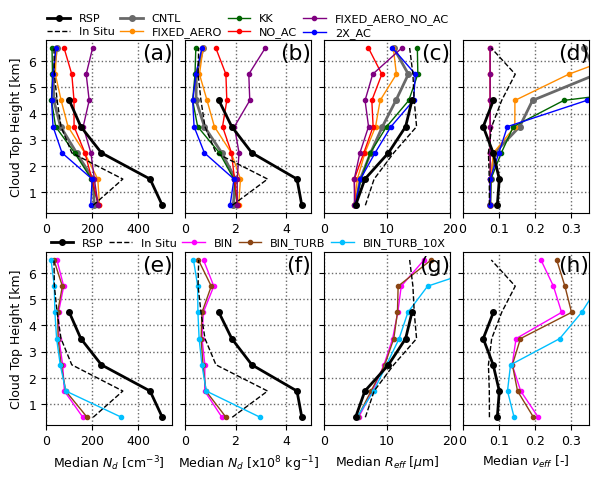

done


In [23]:
#===============================================
# Medians
#===============================================
color1='dimgrey' # CNTL--black will be used for observations
color2='darkorange'
color3='darkgreen'
color4='red'
color5='purple'
color6='blue'
color7='magenta' # CNTL--black will be used for observations
color8='saddlebrown'
color9='deepskyblue'
bulk_labels=['CNTL','FIXED_AERO','KK','NO_AC','FIXED_AERO_NO_AC','2X_AC']
bin_labels=['BIN','BIN_TURB','BIN_TURB_10X']

bulk_colors = [color1,color2,color3,color4,color5,color6]
bin_colors = [color7,color8,color9]

fig = plt.figure(figsize=(7,5))
ax1 = fig.add_subplot(241)
ax2 = fig.add_subplot(242)
ax3 = fig.add_subplot(243)
ax4 = fig.add_subplot(244)
ax5 = fig.add_subplot(245)
ax6 = fig.add_subplot(246)
ax7 = fig.add_subplot(247)
ax8 = fig.add_subplot(248)
Fontsize=9
axlist = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]
for ax in axlist:
    ax.grid(lw=1,ls='dotted',c='dimgrey')
    ax.tick_params(labelsize=Fontsize)
    ax.set_yticks(np.arange(1,7,1))
    ax.set_yticklabels([])
    #ax.set_xticklabels([])
ax1.set_ylabel('Cloud Top Height [km]',fontsize=Fontsize)
ax5.set_ylabel('Cloud Top Height [km]',fontsize=Fontsize)
    
ax5.set_xlabel('Median $N_{d}$ [cm$^{-3}$]',fontsize=Fontsize)
ax6.set_xlabel('Median $N_{d}$ [x10$^{8}$ kg$^{-1}$]',fontsize=Fontsize)
ax7.set_xlabel('Median $R_{eff}$ [$\\mu$m]',fontsize=Fontsize)
ax8.set_xlabel('Median $\\nu_{eff}$ [-]',fontsize=Fontsize)
    
ax1.set_yticklabels(np.arange(1,7,1))
ax5.set_yticklabels(np.arange(1,7,1))
    
markersize1=4
markersize2=3
lw1=2
lw2=1
    
    
#=====================================
# Bulk Simulations
#=====================================
dumi=0
for sim in bulk_sims:
    if dumi==0.:
        tmp_markersize=markersize1
        tmp_lw=lw1
    else:
        tmp_markersize=markersize2
        tmp_lw=lw2
    ax1.plot(ct_stats_dict[sim]['ct_qnl_lt_200um_cc']['50'],cth_midbins,c=bulk_colors[dumi],marker='o',markersize=tmp_markersize,lw=tmp_lw,label=bulk_labels[dumi])
    ax2.plot(ct_stats_dict[sim]['ct_qnl_lt_200um']['50']*1.e-8,cth_midbins,c=bulk_colors[dumi],marker='o',markersize=tmp_markersize,lw=tmp_lw,label=bulk_labels[dumi])
    ax3.plot(ct_stats_dict[sim]['ct_reff_l_lt_200um']['50'],cth_midbins,c=bulk_colors[dumi],marker='o',markersize=tmp_markersize,lw=tmp_lw,label=bulk_labels[dumi])
    ax4.plot(ct_stats_dict[sim]['ct_veff_l_lt_200um']['50'],cth_midbins,c=bulk_colors[dumi],marker='o',markersize=tmp_markersize,lw=tmp_lw,label=bulk_labels[dumi])
    #ax1.plot(ct_stats_dict[sim]['ct_qnl_lt_100um_cc']['50'],cth_midbins,c=bulk_colors[dumi],marker='o',markersize=tmp_markersize,lw=tmp_lw,label=bulk_labels[dumi])
    #ax2.plot(ct_stats_dict[sim]['ct_qnl_lt_100um']['50']*1.e-8,cth_midbins,c=bulk_colors[dumi],marker='o',markersize=tmp_markersize,lw=tmp_lw,label=bulk_labels[dumi])
    #ax3.plot(ct_stats_dict[sim]['ct_reff_l_lt_100um']['50'],cth_midbins,c=bulk_colors[dumi],marker='o',markersize=tmp_markersize,lw=tmp_lw,label=bulk_labels[dumi])
    #ax4.plot(ct_stats_dict[sim]['ct_veff_l_lt_100um']['50'],cth_midbins,c=bulk_colors[dumi],marker='o',markersize=tmp_markersize,lw=tmp_lw,label=bulk_labels[dumi])
    dumi+=1    
    
#=====================================
# Bin Simulations
#=====================================
dumi=0
for sim in bin_sims:
    tmp_markersize=markersize2
    tmp_lw=lw2
    #ax5.plot(bin_ct_stats_dict[sim]['ct_qnl_lt_200um_cc']['50'],cth_midbins,c=bin_colors[dumi],marker='o',markersize=tmp_markersize,lw=tmp_lw,label=bin_labels[dumi])
    #ax6.plot(bin_ct_stats_dict[sim]['ct_qnl_lt_200um']['50']*1.e-8,cth_midbins,c=bin_colors[dumi],marker='o',markersize=tmp_markersize,lw=tmp_lw,label=bin_labels[dumi])
    #ax7.plot(bin_ct_stats_dict[sim]['ct_reff_l_lt_200um']['50'],cth_midbins,c=bin_colors[dumi],marker='o',markersize=tmp_markersize,lw=tmp_lw,label=bin_labels[dumi])
    #ax8.plot(bin_ct_stats_dict[sim]['ct_veff_l_lt_200um']['50'],cth_midbins,c=bin_colors[dumi],marker='o',markersize=tmp_markersize,lw=tmp_lw,label=bin_labels[dumi])
    ax5.plot(bin_ct_stats_dict[sim]['ct_qnl_lt_200um_cc']['50'],cth_midbins,c=bin_colors[dumi],marker='o',markersize=tmp_markersize,lw=tmp_lw,label=bin_labels[dumi])
    ax6.plot(bin_ct_stats_dict[sim]['ct_qnl_lt_200um']['50']*1.e-8,cth_midbins,c=bin_colors[dumi],marker='o',markersize=tmp_markersize,lw=tmp_lw,label=bin_labels[dumi])
    ax7.plot(bin_ct_stats_dict[sim]['ct_reff_l_lt_200um']['50'],cth_midbins,c=bin_colors[dumi],marker='o',markersize=tmp_markersize,lw=tmp_lw,label=bin_labels[dumi])
    ax8.plot(bin_ct_stats_dict[sim]['ct_veff_l_lt_200um']['50'],cth_midbins,c=bin_colors[dumi],marker='o',markersize=tmp_markersize,lw=tmp_lw,label=bin_labels[dumi])
    dumi+=1
    
ax1.set_xlim(0,550)
ax5.set_xlim(0,550)
ax2.set_xlim(0,5)
ax6.set_xlim(0,5)
ax3.set_xlim(0,20)
ax7.set_xlim(0,20)


#ax4.set_xticks([0,200,400])
#ax4.set_xticklabels([0,200,400])
#ax5.set_xticks([0,2,4])
#ax5.set_xticklabels([0,2,4])
#ax6.set_xticks([0,10,20])
#ax6.set_xticklabels([0,10,20])

# RSP
ax1.plot(rsp_ct_perc_dict['nd']['50'],cth_midbins,c='k',marker='o',markersize=markersize1,lw=lw1)
ax5.plot(rsp_ct_perc_dict['nd']['50'],cth_midbins,c='k',marker='o',markersize=markersize1,lw=lw1)
ax2.plot(rsp_ct_perc_dict['nd']['50']/ct_stats_dict['cntl']['ct_rho']['mean']*1.e6*1.e-8,cth_midbins,c='k',marker='o',markersize=markersize1,lw=lw1)
ax6.plot(rsp_ct_perc_dict['nd']['50']/ct_stats_dict['cntl']['ct_rho']['mean']*1.e6*1.e-8,cth_midbins,c='k',marker='o',markersize=markersize1,lw=lw1)
ax3.plot(rsp_ct_perc_dict['Reff']['50'],cth_midbins,c='k',marker='o',markersize=markersize1,lw=lw1)
ax7.plot(rsp_ct_perc_dict['Reff']['50'],cth_midbins,c='k',marker='o',markersize=markersize1,lw=lw1)
ax4.plot(rsp_ct_perc_dict['v_e']['50'],cth_midbins,c='k',marker='o',markersize=markersize1,lw=lw1)
ax8.plot(rsp_ct_perc_dict['v_e']['50'],cth_midbins,c='k',marker='o',markersize=markersize1,lw=lw1)

# FFSSP
ax1.plot(ffssp_perc_dict['conc']['50']*1.e-3,cth_midbins,c='k',lw=lw2,ls='dashed')
ax5.plot(ffssp_perc_dict['conc']['50']*1.e-3,cth_midbins,c='k',lw=lw2,ls='dashed')
ax2.plot(ffssp_perc_dict['conc']['50']*1.e-3/ct_stats_dict['cntl']['ct_rho']['mean']*1.e6*1.e-8,cth_midbins,c='k',lw=lw2,ls='dashed')
ax6.plot(ffssp_perc_dict['conc']['50']*1.e-3/ct_stats_dict['cntl']['ct_rho']['mean']*1.e6*1.e-8,cth_midbins,c='k',lw=lw2,ls='dashed')
ax3.plot(ffssp_perc_dict['reff']['50'],cth_midbins,c='k',lw=lw2,ls='dashed')
ax7.plot(ffssp_perc_dict['reff']['50'],cth_midbins,c='k',lw=lw2,ls='dashed')
ax4.plot(ffssp_perc_dict['veff']['50'],cth_midbins,c='k',lw=lw2,ls='dashed')
ax8.plot(ffssp_perc_dict['veff']['50'],cth_midbins,c='k',lw=lw2,ls='dashed')

bbox=dict(facecolor='wheat', edgecolor='black', boxstyle='square,pad=0.2',alpha=1)

#ax1.text(0.97,0.97,'$N_{d} [cm$^{-3}$]$',fontsize=Fontsize*2,c='k',fontweight='bold',bbox=bbox,transform=ax1.transAxes,ha='right',va='top')
#ax2.text(0.97,0.97,'$N_{d} [kg$^{-1}$]$',fontsize=Fontsize*2,c='k',fontweight='bold',bbox=bbox,transform=ax2.transAxes,ha='right',va='top')
#ax3.text(0.03,0.97,'$R_{eff}$',fontsize=Fontsize*2,c='k',fontweight='bold',bbox=bbox,transform=ax3.transAxes,ha='left',va='top')

lgnd_elements = [Line2D([0],[0],marker='o',color='k',label='RSP',markerfacecolor='k',markersize=markersize1,lw=lw1),\
                 Line2D([0],[0],color='k',label='In Situ',ls='dashed',lw=lw2),\
                 Line2D([0],[0],marker='o',color=color1,label=bulk_labels[0],markerfacecolor=color1,markersize=markersize1,lw=lw1),\
                 Line2D([0],[0],marker='o',color=color2,label=bulk_labels[1],markerfacecolor=color2,markersize=markersize2,lw=lw2),\
                 Line2D([0],[0],marker='o',color=color3,label=bulk_labels[2],markerfacecolor=color3,markersize=markersize2,lw=lw2),\
                 Line2D([0],[0],marker='o',color=color4,label=bulk_labels[3],markerfacecolor=color4,markersize=markersize2,lw=lw2),\
                 Line2D([0],[0],marker='o',color=color5,label=bulk_labels[4],markerfacecolor=color5,markersize=markersize2,lw=lw2),\
                 Line2D([0],[0],marker='o',color=color6,label=bulk_labels[5],markerfacecolor=color6,markersize=markersize2,lw=lw2),\
                ]
ax1.legend(handles=lgnd_elements,fontsize=Fontsize*0.9,loc='upper center',bbox_to_anchor=(1.6,1.21),framealpha=False,ncol=4,labelspacing=0.25,columnspacing=0.5)

lgnd_elements = [Line2D([0],[0],marker='o',color='k',label='RSP',markerfacecolor='k',markersize=markersize1,lw=lw1),\
                 Line2D([0],[0],color='k',label='In Situ',ls='dashed',lw=lw2),\
                 Line2D([0],[0],marker='o',color=color7,label=bin_labels[0],markerfacecolor=color7,markersize=markersize2,lw=lw2),\
                 Line2D([0],[0],marker='o',color=color8,label=bin_labels[1],markerfacecolor=color8,markersize=markersize2,lw=lw2),\
                 Line2D([0],[0],marker='o',color=color9,label=bin_labels[2],markerfacecolor=color9,markersize=markersize2,lw=lw2),\
                ]
ax5.legend(handles=lgnd_elements,fontsize=Fontsize*0.9,loc='upper center',bbox_to_anchor=(1.6,1.14),framealpha=False,ncol=5,labelspacing=0.25,columnspacing=0.5)


labs=['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)']
dumi=0
for ax in axlist:
    ax.text(1,0.98,labs[dumi],transform=ax.transAxes,ha='right',va='top',fontsize=Fontsize*1.75)
    dumi+=1
    
ax4.set_xlim(0,0.35)
ax8.set_xlim(0,0.35)
#ax4.set_xticks([0,0.2,0.4])
#ax8.set_xticks([0,0.2,0.4])
ax4.set_xticks([0,0.1,0.2,0.3])
ax8.set_xticks([0,0.1,0.2,0.3])
#ax4.set_xticklabels(['0','0.2','0.4'])
#ax8.set_xticklabels(['0','0.2','0.4'])
ax4.set_xticklabels(['0','0.1','0.2','0.3'])
ax8.set_xticklabels(['0','0.1','0.2','0.3'])


plt.subplots_adjust(wspace=0.1,hspace=0.225)

fig_path = '/discover/nobackup/mwstanfo/figures/camp2ex_paper/'
#outfile = 'fig_08.png'
outfile = 'fig_ct_profiles.png'
#plt.savefig(fig_path+outfile,dpi=300,bbox_inches='tight')
plt.show()
plt.close()
print('done')

# Versin of Fig. 8 that doesn't include effective variance

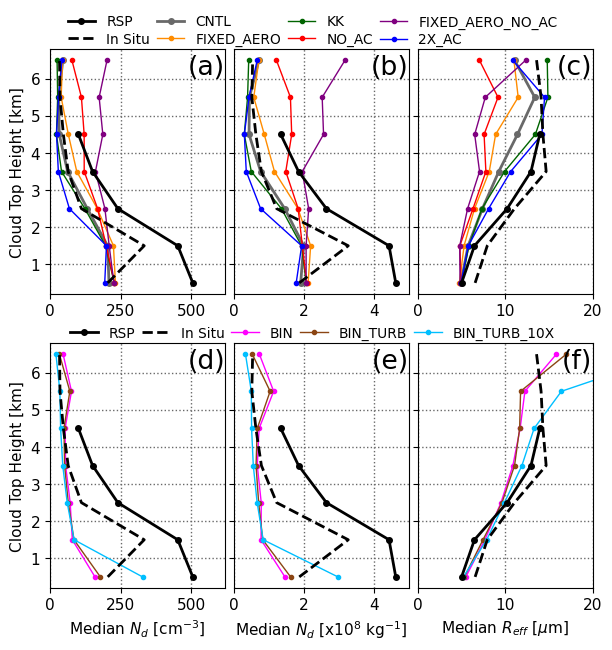

In [19]:
#===============================================
# Medians
#===============================================
color1='dimgrey' # CNTL--black will be used for observations
color2='darkorange'
color3='darkgreen'
color4='red'
color5='purple'
color6='blue'
color7='magenta' # CNTL--black will be used for observations
color8='saddlebrown'
color9='deepskyblue'
bulk_labels=['CNTL','FIXED_AERO','KK','NO_AC','FIXED_AERO_NO_AC','2X_AC']
bin_labels=['BIN','BIN_TURB','BIN_TURB_10X']

bulk_colors = [color1,color2,color3,color4,color5,color6]
bin_colors = [color7,color8,color9]

fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)
Fontsize=11
axlist = [ax1,ax2,ax3,ax4,ax5,ax6]
for ax in axlist:
    ax.grid(lw=1,ls='dotted',c='dimgrey')
    ax.tick_params(labelsize=Fontsize)
    ax.set_yticks(np.arange(1,7,1))
    ax.set_yticklabels([])
    #ax.set_xticklabels([])
ax1.set_ylabel('Cloud Top Height [km]',fontsize=Fontsize)
ax4.set_ylabel('Cloud Top Height [km]',fontsize=Fontsize)
    
ax4.set_xlabel('Median $N_{d}$ [cm$^{-3}$]',fontsize=Fontsize)
ax5.set_xlabel('Median $N_{d}$ [x10$^{8}$ kg$^{-1}$]',fontsize=Fontsize)
ax6.set_xlabel('Median $R_{eff}$ [$\\mu$m]',fontsize=Fontsize)
    
ax1.set_yticklabels(np.arange(1,7,1))
ax4.set_yticklabels(np.arange(1,7,1))
    
markersize1=4
markersize2=3
lw1=2
lw2=1
    
    
#=====================================
# Bulk Simulations
#=====================================
dumi=0
for sim in bulk_sims:
    if dumi==0.:
        tmp_markersize=markersize1
        tmp_lw=lw1
    else:
        tmp_markersize=markersize2
        tmp_lw=lw2
    ax1.plot(ct_stats_dict[sim]['ct_qnl_lt_200um_cc']['50'],cth_midbins,c=bulk_colors[dumi],marker='o',markersize=tmp_markersize,lw=tmp_lw,label=bulk_labels[dumi])
    ax2.plot(ct_stats_dict[sim]['ct_qnl_lt_200um']['50']*1.e-8,cth_midbins,c=bulk_colors[dumi],marker='o',markersize=tmp_markersize,lw=tmp_lw,label=bulk_labels[dumi])
    ax3.plot(ct_stats_dict[sim]['ct_reff_l_lt_200um']['50'],cth_midbins,c=bulk_colors[dumi],marker='o',markersize=tmp_markersize,lw=tmp_lw,label=bulk_labels[dumi])
    dumi+=1
    
    
#=====================================
# Bin Simulations
#=====================================
dumi=0
for sim in bin_sims:
    tmp_markersize=markersize2
    tmp_lw=lw2
    ax4.plot(bin_ct_stats_dict[sim]['ct_qnl_lt_200um_cc']['50'],cth_midbins,c=bin_colors[dumi],marker='o',markersize=tmp_markersize,lw=tmp_lw,label=bin_labels[dumi])
    ax5.plot(bin_ct_stats_dict[sim]['ct_qnl_lt_200um']['50']*1.e-8,cth_midbins,c=bin_colors[dumi],marker='o',markersize=tmp_markersize,lw=tmp_lw,label=bin_labels[dumi])
    ax6.plot(bin_ct_stats_dict[sim]['ct_reff_l_lt_200um']['50'],cth_midbins,c=bin_colors[dumi],marker='o',markersize=tmp_markersize,lw=tmp_lw,label=bin_labels[dumi])
    dumi+=1
    
ax1.set_xlim(0,620)
ax4.set_xlim(0,620)
ax2.set_xlim(0,5)
ax5.set_xlim(0,5)
ax3.set_xlim(0,20)
ax6.set_xlim(0,20)

#ax4.set_xticks([0,200,400])
#ax4.set_xticklabels([0,200,400])
#ax5.set_xticks([0,2,4])
#ax5.set_xticklabels([0,2,4])
#ax6.set_xticks([0,10,20])
#ax6.set_xticklabels([0,10,20])

# RSP
ax1.plot(rsp_ct_perc_dict['nd']['50'],cth_midbins,c='k',marker='o',markersize=markersize1,lw=lw1)
ax4.plot(rsp_ct_perc_dict['nd']['50'],cth_midbins,c='k',marker='o',markersize=markersize1,lw=lw1)
ax2.plot(rsp_ct_perc_dict['nd']['50']/ct_stats_dict['cntl']['ct_rho']['mean']*1.e6*1.e-8,cth_midbins,c='k',marker='o',markersize=markersize1,lw=lw1)
ax5.plot(rsp_ct_perc_dict['nd']['50']/ct_stats_dict['cntl']['ct_rho']['mean']*1.e6*1.e-8,cth_midbins,c='k',marker='o',markersize=markersize1,lw=lw1)
ax3.plot(rsp_ct_perc_dict['Reff']['50'],cth_midbins,c='k',marker='o',markersize=markersize1,lw=lw1)
ax6.plot(rsp_ct_perc_dict['Reff']['50'],cth_midbins,c='k',marker='o',markersize=markersize1,lw=lw1)

# FFSSP
ax1.plot(ffssp_perc_dict['conc']['50']*1.e-3,cth_midbins,c='k',lw=lw1,ls='dashed')
ax4.plot(ffssp_perc_dict['conc']['50']*1.e-3,cth_midbins,c='k',lw=lw1,ls='dashed')
ax2.plot(ffssp_perc_dict['conc']['50']*1.e-3/ct_stats_dict['cntl']['ct_rho']['mean']*1.e6*1.e-8,cth_midbins,c='k',lw=lw1,ls='dashed')
ax5.plot(ffssp_perc_dict['conc']['50']*1.e-3/ct_stats_dict['cntl']['ct_rho']['mean']*1.e6*1.e-8,cth_midbins,c='k',lw=lw1,ls='dashed')
ax3.plot(ffssp_perc_dict['reff']['50'],cth_midbins,c='k',lw=lw1,ls='dashed')
ax6.plot(ffssp_perc_dict['reff']['50'],cth_midbins,c='k',lw=lw1,ls='dashed')

bbox=dict(facecolor='wheat', edgecolor='black', boxstyle='square,pad=0.2',alpha=1)

#ax1.text(0.97,0.97,'$N_{d} [cm$^{-3}$]$',fontsize=Fontsize*2,c='k',fontweight='bold',bbox=bbox,transform=ax1.transAxes,ha='right',va='top')
#ax2.text(0.97,0.97,'$N_{d} [kg$^{-1}$]$',fontsize=Fontsize*2,c='k',fontweight='bold',bbox=bbox,transform=ax2.transAxes,ha='right',va='top')
#ax3.text(0.03,0.97,'$R_{eff}$',fontsize=Fontsize*2,c='k',fontweight='bold',bbox=bbox,transform=ax3.transAxes,ha='left',va='top')

lgnd_elements = [Line2D([0],[0],marker='o',color='k',label='RSP',markerfacecolor='k',markersize=markersize1,lw=lw1),\
                 Line2D([0],[0],color='k',label='In Situ',ls='dashed',lw=lw1),\
                 Line2D([0],[0],marker='o',color=color1,label=bulk_labels[0],markerfacecolor=color1,markersize=markersize1,lw=lw1),\
                 Line2D([0],[0],marker='o',color=color2,label=bulk_labels[1],markerfacecolor=color2,markersize=markersize2,lw=lw2),\
                 Line2D([0],[0],marker='o',color=color3,label=bulk_labels[2],markerfacecolor=color3,markersize=markersize2,lw=lw2),\
                 Line2D([0],[0],marker='o',color=color4,label=bulk_labels[3],markerfacecolor=color4,markersize=markersize2,lw=lw2),\
                 Line2D([0],[0],marker='o',color=color5,label=bulk_labels[4],markerfacecolor=color5,markersize=markersize2,lw=lw2),\
                 Line2D([0],[0],marker='o',color=color6,label=bulk_labels[5],markerfacecolor=color6,markersize=markersize2,lw=lw2),\
                ]
ax1.legend(handles=lgnd_elements,fontsize=Fontsize*0.9,loc='upper center',bbox_to_anchor=(1.5,1.19),framealpha=False,ncol=4,labelspacing=0.25,columnspacing=0.5)

lgnd_elements = [Line2D([0],[0],marker='o',color='k',label='RSP',markerfacecolor='k',markersize=markersize1,lw=lw1),\
                 Line2D([0],[0],color='k',label='In Situ',ls='dashed',lw=lw1),\
                 Line2D([0],[0],marker='o',color=color7,label=bin_labels[0],markerfacecolor=color7,markersize=markersize2,lw=lw2),\
                 Line2D([0],[0],marker='o',color=color8,label=bin_labels[1],markerfacecolor=color8,markersize=markersize2,lw=lw2),\
                 Line2D([0],[0],marker='o',color=color9,label=bin_labels[2],markerfacecolor=color9,markersize=markersize2,lw=lw2),\
                ]
ax4.legend(handles=lgnd_elements,fontsize=Fontsize*0.9,loc='upper center',bbox_to_anchor=(1.5,1.12),framealpha=False,ncol=5,labelspacing=0.25,columnspacing=0.5)


labs=['(a)','(b)','(c)','(d)','(e)','(f)']
dumi=0
for ax in axlist:
    ax.text(1,0.98,labs[dumi],transform=ax.transAxes,ha='right',va='top',fontsize=Fontsize*1.75)
    dumi+=1


plt.subplots_adjust(wspace=0.05,hspace=0.2)

fig_path = '/discover/nobackup/mwstanfo/figures/camp2ex_paper/'
outfile = 'fig_08.png'
#outfile = 'fig_ct_profiles.png'
#plt.savefig(fig_path+outfile,dpi=300,bbox_inches='tight')
plt.show()
plt.close()

# Calculate relative differences of median Nd for FIXED_AERO and NO_AC simulations relative to CNTL for quantification in bulleted list in the Conclusions section of manuscript

In [20]:
cntl_med_qnl = ct_stats_dict['cntl']['ct_qnl_lt_200um_cc']['50']
fixed_aero_med_qnl = ct_stats_dict['fixed_aero']['ct_qnl_lt_200um_cc']['50']
fixed_aero_no_ac_med_qnl = ct_stats_dict['fixed_aero_no_cc']['ct_qnl_lt_200um_cc']['50']
no_ac_med_qnl = ct_stats_dict['no_cc']['ct_qnl_lt_200um_cc']['50']

In [21]:
for kk in range(len(cth_midbins)):
    tmp_fixed_aero_med_qnl = fixed_aero_med_qnl[kk]
    tmp_fixed_aero_no_ac_med_qnl = fixed_aero_no_ac_med_qnl[kk]
    tmp_no_ac_med_qnl = no_ac_med_qnl[kk]
    tmp_cntl_med_qnl = cntl_med_qnl[kk]
    
    fixed_aero_rel_diff = (tmp_fixed_aero_med_qnl - tmp_cntl_med_qnl)/tmp_cntl_med_qnl*100.
    fixed_aero_no_ac_rel_diff = (tmp_fixed_aero_no_ac_med_qnl - tmp_cntl_med_qnl)/tmp_cntl_med_qnl*100.
    no_ac_rel_diff = (tmp_no_ac_med_qnl - tmp_cntl_med_qnl)/tmp_cntl_med_qnl*100.
    print('CTH:',cth_midbins[kk])
    print('      FIXED_AERO_NO_AC:',fixed_aero_no_ac_rel_diff)
    print('            FIXED_AERO:',fixed_aero_rel_diff)
    print('                 NO_AC:',no_ac_rel_diff)
    

CTH: 0.5
      FIXED_AERO_NO_AC: 8.354555570386637
            FIXED_AERO: 10.927335523860641
                 NO_AC: 9.223097728839546
CTH: 1.5
      FIXED_AERO_NO_AC: 2.738173180951065
            FIXED_AERO: 10.125091553204856
                 NO_AC: -2.486686390705408
CTH: 2.5
      FIXED_AERO_NO_AC: 47.13361549872107
            FIXED_AERO: 26.67252199912123
                 NO_AC: 27.523575438249146
CTH: 3.5
      FIXED_AERO_NO_AC: 158.33065244318476
            FIXED_AERO: 52.09116120884981
                 NO_AC: 94.34695617573561
CTH: 4.5
      FIXED_AERO_NO_AC: 472.6924673207832
            FIXED_AERO: 98.58587633928376
                 NO_AC: 270.2185256497286
CTH: 5.5
      FIXED_AERO_NO_AC: 469.4203290891644
            FIXED_AERO: 29.241176261256886
                 NO_AC: 264.0143910705264
CTH: 6.5
      FIXED_AERO_NO_AC: 345.7329142324656
            FIXED_AERO: -2.325996700969834
                 NO_AC: 71.04919410484386
